## Part A: Subreddit Prediction ##

In [5]:
subreddit_train = "coursework_subreddit_train.json"
subreddit_test = "coursework_subreddit_test.json"

!gsutil cp gs://textasdata/coursework/coursework_subreddit_train.json $subreddit_train 
!gsutil cp gs://textasdata/coursework/coursework_subreddit_test.json  $subreddit_test

Copying gs://textasdata/coursework/coursework_subreddit_train.json...
- [1 files][ 10.1 MiB/ 10.1 MiB]                                                
Operation completed over 1 objects/10.1 MiB.                                     
Copying gs://textasdata/coursework/coursework_subreddit_test.json...
- [1 files][  2.7 MiB/  2.7 MiB]                                                
Operation completed over 1 objects/2.7 MiB.                                      


In [6]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import numpy as np

tokenizer = RegexpTokenizer(r'\w+')
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
  
def canonicalize(string):
  normalized_tokens = list()
  tokens = tokenizer.tokenize(string)
  for token in tokens:
    if token.lower() not in stop_words and len(token) > 1 and len(token) < 24:
      normalized = stemmer.stem(token.lower())
      normalized_tokens.append(normalized)
  return normalized_tokens

def canonicalize_withoutstem(string):
  normalized_tokens = list()
  tokens = tokenizer.tokenize(string)
  for token in tokens:
    if token.lower() not in stop_words and len(token) > 1 and len(token) < 24:
      normalized = token.lower()
      normalized_tokens.append(normalized)
  return normalized_tokens

def eval_summary(name, predictions, labels):
  precision = precision_score(predictions, labels,average='macro')
  recall = recall_score(predictions, labels,average='macro')
  accuracy = accuracy_score(predictions, labels)
  f1 = fbeta_score(predictions, labels, 1,average='macro') #1 means f_1 measure
  print('\nConfusion matrix:\n',confusion_matrix(labels, predictions))
  print("Classifier '%s' has P=%0.3f R=%0.3f Acc=%0.3f F1=%0.3f" % (name,precision,recall,accuracy,f1) )
  print(classification_report(predictions, labels))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
#!python -m spacy download en

import spacy

# Load the small english model. 
# Disable the advanced NLP features in the pipeline for efficiency.
nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')

#@Tokenize
def spacy_tokenize(string):
  tokens = list()
  doc = nlp(string)
  for token in doc:
    tokens.append(token)
  return tokens

#@Normalize
def normalize(tokens):
  normalized_tokens = list()
  for token in tokens:
    if (token.is_alpha or token.is_digit):
      normalized = token.text.lower().strip()
      normalized_tokens.append(normalized)
  return normalized_tokens

#@Tokenize and normalize
def tokenize_normalize(string):
  return normalize(spacy_tokenize(string))  

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.    """

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [9]:
import pandas as pd

train_threads = pd.read_json(path_or_buf=subreddit_train, lines=True)
print(list(train_threads.columns.values))
print(train_threads.head())
print(train_threads.size)

['is_self_post', 'posts', 'subreddit', 'title', 'url']
   is_self_post                                              posts  \
0           1.0  [{'body': 'I think everyone has that one frien...   
1           1.0  [{'body': 'I not 100% sure this is the right p...   
2           1.0  [{'body': '', 'author': 'Leisure321', 'url': '...   
3           1.0  [{'body': 'It's called 'forgetting things'.', ...   
4           1.0  [{'body': 'How would I do this? I am looking t...   

        subreddit                                              title  \
0   relationships  How do I [23F] communicate with my self-center...   
1  summonerschool  What Cherry switch do you recommend for League...   
2       askreddit                   Where do memes go when they die?   
3           trees                     Some weird long term affects??   
4        buildapc  Simple question: If I install Windows to a sta...   

                                                 url  
0  https://www.reddit.com/r/relation

In [6]:
test_threads = pd.read_json(path_or_buf=subreddit_test, lines=True)
print(test_threads.head())
print(test_threads.size)

   is_self_post                                              posts  \
0           1.0  [{'body': 'Was watching a VOD from last years ...   
1           1.0  [{'body': 'Basically what the title says.', 'u...   
2           1.0  [{'body': '', 'author': 'Daft-Punk', 'url': 'h...   
3           1.0  [{'body': 'I start running this year. I do it ...   
4           1.0  [{'body': '[deleted]', 'url': 'https://www.red...   

       subreddit                                              title  \
0      starcraft  Just a reminder on how much SC2 has evolved th...   
1    whowouldwin  Your Favorite Hero Now Has A Healing Factor As...   
2      askreddit  If you could live anywhere in the world, where...   
3      askreddit                   Do you ever get use to exercise?   
4  tipofmytongue         [TOMT] [book] A scary french book for kids   

                                                 url  
0  https://www.reddit.com/r/starcraft/comments/mq...  
1  https://www.reddit.com/r/whowouldwin/co

In [7]:
subreddit_train_group = list()
subreddit_test_group = list()
subreddit_train = []
subreddit_test = []
subreddit_train_title = train_threads['title']
subreddit_test_title = test_threads['title']

for count in range(len(train_threads['posts'])):
  gather_body = list()
  gather_authorid = list()
  for k in range(len(train_threads['posts'][count])):
    if 'body' in train_threads['posts'][count][k]:
        if (train_threads['posts'][count][k]["body"] is not None):
          gather_body.append(train_threads['posts'][count][k]['body'])
          if (train_threads['posts'][count][k].get('author') is not None):
            gather_authorid.append(train_threads['posts'][count][k].get('author'))
    
  if(subreddit_train_title[count] is not None):
    subreddit_train_group.append((' '.join(gather_authorid),subreddit_train_title[count]," ".join(gather_body)))
#     print(subreddit_train_group)
    collabels = ['authorId', 'title', 'body']
    subreddit_train = pd.DataFrame(subreddit_train_group, columns=collabels)
    
#     gather_authorid.append(': '+subreddit_train_title[count])
#     gather_authorid.append(" ".join(gather_body))
#   subreddit_train_group.append(" ".join(gather_authorid))      
# print(subreddit_train_group[1])

for count in range(len(test_threads['posts'])):
  gather_body = list()
  gather_authorid = list()
  for k in range(len(test_threads['posts'][count])):
    if 'body' in test_threads['posts'][count][k]:
        if (test_threads['posts'][count][k]["body"] is not None ):
          gather_body.append(test_threads['posts'][count][k]['body'])
          if (test_threads['posts'][count][k].get('author') is not None ):
            gather_authorid.append(test_threads['posts'][count][k].get('author'))
    
  if(subreddit_test_title[count] is not None):
    subreddit_test_group.append((' '.join(gather_authorid),subreddit_test_title[count]," ".join(gather_body)))
    
    collabels = ['authorId', 'title', 'body']
    subreddit_test = pd.DataFrame(subreddit_test_group, columns=collabels)
#     gather_authorid.append((subreddit_test_title[count],gather_body))
#     gather_authorid.append(" ".join(gather_body))

  
  
# len(subreddit_test_group)
subreddit_test
subreddit_train

authorId  \
0     Pouritdownmythroat WhyFrankWhy Pouritdownmythr...   
1     ThisGermanGuy shaunrnm Sub_Salac MisterBlack8 ...   
2     Leisure321 Zeolance Buttersgoo23 quzimaa Escap...   
3        refugee4chan donquixote6179 ThatStonedAsianGuy   
4              catalyzeme uses rvabdn greg2709 spydr101   
5     gpacman21 jeansplice Ame-no-nobuko vadergeek A...   
6     ellosmello fozzix VarusMidOrAfk I_know_where_y...   
7     walkngonawire ResonantCascade snicklepants jui...   
8      patrick6h aBoglehead thisismyfirstpost twblalock   
9     CrazyChunckMaster420 xmodusterz Frogad Waheyy ...   
10    throwaway51711 Lorimor Lorimor GCanuck throwaw...   
11                   jcsix CharlieKillsRats jcsix jcsix   
12                                       jamvanderloeff   
13    ParadoxAnarchy VeteranCommander 28thsundown Ez...   
14    vanasbry000 Jinjetsu derindel Skyegg Doughy123...   
15    SPL1TT3R gtgoku SPL1TT3R gtgoku SPL1TT3R gtgok...   
16    CalonTost Winkn cantthinkofaCO0Lname badmak ka...   
17    Tape_measure scienceteacherguy Tape_measure br...   
18                       KR_shmungler zedisfied_ Osiato   
19    Nedrin BecomeWind ColKrismiss rcmaehl ColKrism...   
20    HilbertSystem frisbeefrank HilbertSystem frisb...   
21          Hlaufenberg Noomsi jeffreyharharwood sco154   
22           ouissellat ofMindandHeart Teekno riconquer   
23    deadgreysn0w froschkonig deadgreysn0w froschko...   
24    Jayavarmen OyleSlyck Finckel dz5b605 Jayavarme...   
25    arlanTLDR arlanTLDR omglook joeshlub someaweso...   
26    French87 LakeAndTheRiver dumandizzy inclinedto...   
27    thejumpingasian QwertyPoint TheUnheard blah_bl...   
28    aminakoydum random_____user elvagabundotonto a...   
29    Teillu ToxiClay idetectanerd armena vwlsmssng ...   
...                                                 ...   
1426             ReddestDream ReddestDream ReddestDream   
1427             cabbius maximumcrisis Nekture Hatelore   
1428  Im_not_creepy_am_I cdude HastaLasagna cdude Im...   
1429     Amphabian desertREAPER01 NGRoachClip JakeSteam   
1430  singleforever_ Harangue_itang singleforever_ H...   
1431  blueboybob brikken AllinIRL SnowJoust bfish510...   
1432             tatom TRUBored gumpy5 T400 gumpy5 T400   
1433  Bubminy palcatraz JesusaurusPrime StupidLemonE...   
1434  Rosy_Ps_Boyfriend Goofybud16 Rosy_Ps_Boyfriend...   
1435  BraddardStark BraddardStark BraddardStark Brad...   
1436  BlueD_ Munchman5000 BlueD_ Munchman5000 Munchm...   
1437                   losemybreath yiotta losemybreath   
1438  bigsol81 nomofica trolli_mctroll nomofica trol...   
1439    Velkyria 420donglord TheBeastOnFire Defiantific   
1440  mandysteve mandysteve peg_leg Garbagio qquicks...   
1441  ClavicleRub twelvedayslate Blue_Stuff pridwyn ...   
1442  trajicrabbit biteysaur dorthyway SamsIphone tr...   
1443  Viperking5 taichi_duck Eternal_Princess_Jam Pr...   
1444  Mac1822 highlysober detroyer FuckCracker Ajzsh...   
1445          Tthrond76 aflarge aflarge aflarge aflarge   
1446  what_the_rock_cooked Nambot what_the_rock_cook...   
1447                    Mars200 Mars200 m1kepro Mars200   
1448  Unknof SGTQuackers Protonis Unknof Unknof Pr0d...   
1449      EBDoo EBDoo DDiggler321 MrNewAndImprove EBDoo   
1450  tiaow DeepSpacePandaEUW tiaow dudaseifert Deep...   
1451   IcybossPlays darkaxefire butttcrackjoe 252978104   
1452               kswitch5022 psyEDk Col_Crunch Arch_0   
1453  GoldLeaderLando aedgar777 Xirii screamingherbe...   
1454  funkieturtle DoneAllWrong hopefulthr0waway fun...   
1455  Master_Cen DaylightDarkle BadMessiah Master_Ce...   

                                                  title  \
0     How do I [23F] communicate with my self-center...   
1     What Cherry switch do you recommend for League...   
2                      Where do memes go when they die?   
3                        Some weird long term affects??   
4     Simple question: If I install Windows to a sta...   
5                                S

In [0]:
subreddit_train_group = list()
subreddit_test_group = list()

subreddit_train_title = train_threads['title']
subreddit_test_title = test_threads['title']

for count in range(len(train_threads['posts'])):
  gather_body = list()
  gather_authorid = list()
  for k in range(len(train_threads['posts'][count])):
    if 'body' in train_threads['posts'][count][k]:
        if (train_threads['posts'][count][k]["body"] is not None):
          gather_body.append(train_threads['posts'][count][k]['body'])
          if (train_threads['posts'][count][k].get('author') is not None):
            gather_authorid.append(train_threads['posts'][count][k].get('author'))
    
  if(subreddit_train_title[count] is not None):
#     print(subreddit_train_title[count])
#     print(gather_authorid)
#     print(gather_body)
    gather_authorid.append(': '+subreddit_train_title[count])
    gather_authorid.append(" ".join(gather_body))
  subreddit_train_group.append(' '.join(gather_authorid))    
# print(subreddit_train_group[1])

for count in range(len(test_threads['posts'])):
  gather_body = list()
  gather_authorid = list()
  for k in range(len(test_threads['posts'][count])):
    if 'body' in test_threads['posts'][count][k]:
        if (test_threads['posts'][count][k]["body"] is not None):
          gather_body.append(test_threads['posts'][count][k]['body'])
          if (test_threads['posts'][count][k].get('author') is not None):
            gather_authorid.append(test_threads['posts'][count][k].get('author'))
    
  if(subreddit_test_title[count] is not None):
    gather_authorid.append(' '+subreddit_test_title[count])
    gather_authorid.append(" ".join(gather_body))
  subreddit_test_group.append(" ".join(gather_authorid))
print(subreddit_test_group[0])

MeisterKarl smsy vehemus NruJaC  Just a reminder on how much SC2 has evolved the last 12 months.. Was watching a VOD from last years DreamHack Winter. The first map in the finals (Naama vs Mana) was Lost Temple.. spawning close ground positions..

It's a great sign that shows how much the game is evolving imo. Has anyone else noticed stuff like this? I find it cool that both Mana and Naama made it to the Ro16 in this DH Winter. Shows that they weren't just flashes in the pan. Even better, watch a VOD from [MLG Raleigh](http://tv.majorleaguegaming.com/videos/174-wr4-g2-kiwikaki-vs-nadagast-steppes-of-war-mlg-raleigh-starcraft-2)

The games, the casting, the maps... everything was fucking awful.  Amazing that it was just over one year ago. Wasn't that also an epic and awesome series? I remember it being one of the best series I had seen at that point.


In [0]:
print(len(subreddit_train)
,len(subreddit_test))


1456 365


count     20.000000
mean      72.800000
std       73.368285
min       28.000000
25%       36.250000
50%       45.500000
75%       63.750000
max      334.000000
Name: subreddit, dtype: float64
askreddit               334
leagueoflegends         196
buildapc                131
explainlikeimfive        82
trees                    66
techsupport              63
gaming                   62
pcmasterrace             62
electronic_cigarette     59
relationships            48
tipofmytongue            43
jailbreak                38
hearthstone              38
summonerschool           37
atheism                  37
reddit.com               34
movies                   33
whowouldwin              33
personalfinance          32
starcraft                28
Name: subreddit, dtype: int64


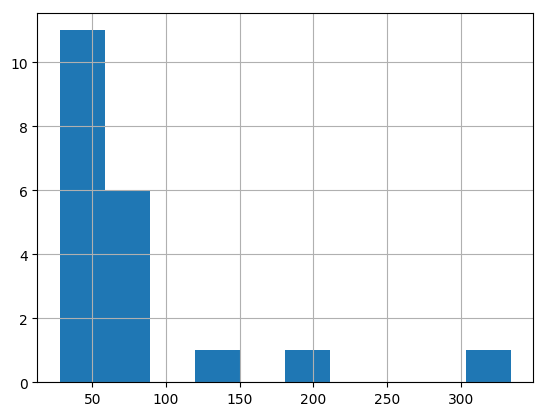

In [0]:
subreddit_counts = train_threads['subreddit'].value_counts()
print(subreddit_counts.describe())
top_subbreddits = subreddit_counts.nlargest(20)
top_subbreddits_list = top_subbreddits.index.tolist()
print(top_subbreddits)
subreddit_counts.hist()

In [0]:
train_labels = train_threads['subreddit']
test_labels = test_threads['subreddit']

In [0]:
import spacy

# Load the medium english model. 
# We will use this model to get embedding features for tokens later.
!python -m spacy download en_core_web_md

nlp = spacy.load('en_core_web_md', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')
print(nlp.pipeline)
# Download a stopword list
import nltk
nltk.download('stopwords')


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_md -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')

[]
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Split dataset into authorid and content.

**One hot encoding**

In [0]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

# Use FeatureUnion to combine the features from text and summary
prediction_pipeline_OHE=[]
prediction_pipeline_OHE = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('authorId', Pipeline([
              ('selector', ItemSelector(key='authorId')),
              ('one-hot', CountVectorizer(tokenizer=canonicalize_withoutstem)), 
              ])),
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('one-hot', CountVectorizer(tokenizer=canonicalize)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('one-hot', CountVectorizer(tokenizer=canonicalize)), 
              ])),
        ])
        )
    ])
# 'authorId', 'title', 'body'

In [0]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

# Use FeatureUnion to combine the features from text and summary
prediction_pipeline_OHE = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('authorId', Pipeline([
              ('selector', ItemSelector(key='authorId')),
              ('one-hot', CountVectorizer(tokenizer=canonicalize)), 
              ])),
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('one-hot', CountVectorizer(tokenizer=canonicalize)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('one-hot', CountVectorizer(tokenizer=canonicalize)), 
              ])),
        ])
        )
    ])
# 'authorId', 'title', 'body'

**TF- IDF**

In [0]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
# Use FeatureUnion to combine the features from text and summary
prediction_pipeline_tfidf=[]
prediction_pipeline_tfidf = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('authorId', Pipeline([
              ('selector', ItemSelector(key='authorId')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize_withoutstem)), 
              ])),
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize)), 
              ])),
        ])
        )
    ])

In [0]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
# Use FeatureUnion to combine the features from text and summary
prediction_pipeline_tfidf = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('authorId', Pipeline([
              ('selector', ItemSelector(key='authorId')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize)), 
              ])),
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize)), 
              ])),
        ])
        )
    ])

Q1 CountVectorizer & TfidfVectorize

In [0]:
# Create a CountVectorizer.
# countvectorizer = CountVectorizer(tokenizer=canonicalize)
countvectorizer_train_matrix = prediction_pipeline_OHE.fit_transform(subreddit_train)
countvectorizer_test_matrix = prediction_pipeline_OHE.transform(subreddit_test)

# Create a TfidfVectorize.
# tfidf_vectorizer = TfidfVectorizer(tokenizer=canonicalize)
tfidf_train_matrix = prediction_pipeline_tfidf.fit_transform(subreddit_train)
tfidf_test_matrix = prediction_pipeline_tfidf.transform(subreddit_test)

In [0]:
print(countvectorizer_train_matrix)
print(tfidf_train_matrix)

  (0, 2482)	2
  (0, 6302)	2
  (0, 8854)	3
  (0, 9278)	1
  (0, 9281)	1
  (0, 9618)	1
  (0, 9775)	1
  (0, 9881)	1
  (0, 10407)	1
  (0, 10463)	1
  (0, 11332)	1
  (0, 11695)	1
  (0, 12316)	1
  (0, 12456)	1
  (0, 13501)	1
  (0, 13679)	2
  (0, 13820)	1
  (0, 14423)	1
  (0, 14501)	1
  (0, 14502)	1
  (0, 14691)	1
  (0, 14739)	1
  (0, 14929)	1
  (0, 15068)	2
  (0, 15072)	1
  :	:
  (1455, 21692)	1
  (1455, 21899)	2
  (1455, 21901)	1
  (1455, 21902)	3
  (1455, 22000)	1
  (1455, 23311)	7
  (1455, 23417)	1
  (1455, 23503)	1
  (1455, 24444)	1
  (1455, 25649)	1
  (1455, 25819)	1
  (1455, 25829)	2
  (1455, 25837)	3
  (1455, 26842)	2
  (1455, 27591)	1
  (1455, 27868)	1
  (1455, 28003)	2
  (1455, 28804)	1
  (1455, 28925)	1
  (1455, 29294)	1
  (1455, 29838)	1
  (1455, 30151)	1
  (1455, 30247)	1
  (1455, 31508)	1
  (1455, 31664)	2
  (0, 2482)	0.4648834776956129
  (0, 6302)	0.49111595126754476
  (0, 8854)	0.7366739269013172
  (0, 9278)	0.33757178332538024
  (0, 9281)	0.3946942524095714
  (0, 9618)	0.229450

In [0]:
print(countvectorizer_train_matrix)
print(tfidf_train_matrix)

  (0, 9505)	0.37796447300922725
  (0, 9506)	0.37796447300922725
  (0, 9507)	0.37796447300922725
  (0, 9508)	0.37796447300922725
  (0, 9509)	0.37796447300922725
  (0, 9510)	0.37796447300922725
  (0, 9511)	0.37796447300922725
  (0, 15150)	0.33757178332538024
  (0, 15153)	0.3946942524095714
  (0, 15490)	0.22945098729733446
  (0, 15647)	0.35865398706688945
  (0, 15753)	0.33757178332538024
  (0, 16279)	0.25218396816617455
  (0, 16335)	0.21614370282349266
  (0, 17204)	0.35865398706688945
  (0, 17567)	0.33757178332538024
  (0, 18188)	0.28657345638152565
  (0, 18328)	0.041003895660327146
  (0, 19373)	0.054834465144691494
  (0, 19551)	0.10205594295186116
  (0, 19692)	0.057003016257265386
  (0, 20295)	0.05501817907580133
  (0, 20373)	0.05311991497357163
  (0, 20374)	0.07644624110153068
  (0, 20563)	0.02718248099154683
  :	:
  (1455, 27564)	0.05078274443488588
  (1455, 27771)	0.14883259725194045
  (1455, 27773)	0.07028954248272766
  (1455, 27774)	0.12683099544583504
  (1455, 27872)	0.094169721211

Q1 LogisticRegression

In [0]:
Logi = LogisticRegression(verbose=True)
print("Logi_countvectorizer_model")

Logi_countvectorizer_model = Logi.fit(countvectorizer_train_matrix,train_labels)
eval_summary("Logi_countvectorizer_test_model", Logi_countvectorizer_model.predict(countvectorizer_test_matrix), test_labels)

print("Logi_tfidf_model")
Logi_tfidf_model = Logi.fit(tfidf_train_matrix,train_labels)
eval_summary("Logi_countvectorizer_test_model", Logi_tfidf_model.predict(tfidf_test_matrix), test_labels)

Logi_countvectorizer_model
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)



Confusion matrix:
 [[74  0  0  0  1  4  0  0  3  0  0  1  0  0  0  0  0  0  1  0]
 [ 4  7  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 3  0 30  0  0  0  0  0  1  0  1  0  0  0  0  0  2  0  0  0]
 [ 1  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 2  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  8  0  0  3  0  4  0  0  0  0  0  0  1  0  0]
 [ 3  0  0  0  0  2  9  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  9  1  0  0  0  0  0  0  0  0  1  0  0]
 [ 5  0  1  0  0  1  0  0 40  0  0  0  0  0  0  1  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  1  0  0]
 [ 2  0  5  0  0  3  0  0  1  0 10  0  0  0  0  0  2  0  0  0]
 [ 1  0  0  0  1  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 2  0  0  0  0  2  0  0  1  0  0  0  1  0  3  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  4  0  0 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
Logi = LogisticRegression(verbose=True)
print("Logi_countvectorizer_model")

Logi_countvectorizer_model = Logi.fit(countvectorizer_train_matrix,train_labels)
eval_summary("Logi_countvectorizer_test_model", Logi_countvectorizer_model.predict(countvectorizer_test_matrix), test_labels)

print("Logi_tfidf_model")
Logi_tfidf_model = Logi.fit(tfidf_train_matrix,train_labels)
eval_summary("Logi_countvectorizer_test_model", Logi_tfidf_model.predict(tfidf_test_matrix), test_labels)

Logi_countvectorizer_model
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)



Confusion matrix:
 [[74  0  0  0  1  4  0  0  3  0  0  1  0  0  0  0  0  0  1  0]
 [ 4  7  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 3  0 30  0  0  0  0  0  1  0  1  0  0  0  0  0  2  0  0  0]
 [ 1  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 2  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  8  0  0  3  0  4  0  0  0  0  0  0  1  0  0]
 [ 3  0  0  0  0  2  9  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  9  1  0  0  0  0  0  0  0  0  1  0  0]
 [ 5  0  1  0  0  1  0  0 40  0  0  0  0  0  0  1  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  1  0  0]
 [ 2  0  5  0  0  3  0  0  1  0 10  0  0  0  0  0  2  0  0  0]
 [ 1  0  0  0  1  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 2  0  0  0  0  2  0  0  1  0  0  0  1  0  3  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  4  0  0 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
Logi = LogisticRegression(verbose=True)
print("Logi_countvectorizer_model")

Logi_countvectorizer_model = Logi.fit(countvectorizer_train_matrix,train_labels)
eval_summary("Logi_countvectorizer_test_model", Logi_countvectorizer_model.predict(countvectorizer_test_matrix), test_labels)

print("Logi_tfidf_model")
Logi_tfidf_model = Logi.fit(tfidf_train_matrix,train_labels)
eval_summary("Logi_countvectorizer_test_model", Logi_tfidf_model.predict(tfidf_test_matrix), test_labels)

Logi_countvectorizer_model
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)



Confusion matrix:
 [[74  0  0  0  1  4  0  0  3  0  0  1  0  0  0  0  0  0  1  0]
 [ 4  7  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 3  0 30  0  0  0  0  0  1  0  1  0  0  0  0  0  2  0  0  0]
 [ 1  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 2  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  8  0  0  3  0  4  0  0  0  0  0  0  1  0  0]
 [ 3  0  0  0  0  2  9  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  9  1  0  0  0  0  0  0  0  0  1  0  0]
 [ 5  0  1  0  0  1  0  0 40  0  0  0  0  0  0  1  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  1  0  0]
 [ 2  0  5  0  0  3  0  0  1  0 10  0  0  0  0  0  2  0  0  0]
 [ 1  0  0  0  1  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 2  0  0  0  0  2  0  0  1  0  0  0  1  0  3  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  4  0  0 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
Logi = LogisticRegression(verbose=True)
print("Logi_countvectorizer_model")

Logi_countvectorizer_model = Logi.fit(countvectorizer_train_matrix,train_labels)
eval_summary("Logi_countvectorizer_test_model", Logi_countvectorizer_model.predict(countvectorizer_test_matrix), test_labels)

print("Logi_tfidf_model")
Logi_tfidf_model = Logi.fit(tfidf_train_matrix,train_labels)
eval_summary("Logi_countvectorizer_test_model", Logi_tfidf_model.predict(tfidf_test_matrix), test_labels)

Logi_countvectorizer_model
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)



Confusion matrix:
 [[75  1  0  0  1  4  0  0  2  0  0  1  0  0  0  0  0  0  0  0]
 [ 4  7  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 2  0 29  0  0  1  0  0  1  0  2  0  0  0  0  0  2  0  0  0]
 [ 1  0  0  7  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  9  0  0  3  0  3  0  0  0  0  0  0  1  0  0]
 [ 4  0  0  0  0  1 10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  8  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0  1  0  0  3  0  0 38  0  0  0  0  0  0  2  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0]
 [ 2  0  6  0  0  2  0  0  1  0 10  0  0  0  0  0  2  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  8  0  1  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 2  0  0  0  0  1  0  0  1  0  0  0  1  0  3  1  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  4  0  0 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Q1 SVCClassifier

In [0]:
Svc = SVC(verbose=True)

print("Svc_countvectorizer_train_model")
Svc_countvectorizer_model=Svc.fit(countvectorizer_train_matrix,train_labels) 
eval_summary("Svc_countvectorizer_train_model", Svc_countvectorizer_model.predict(countvectorizer_test_matrix), test_labels)

print("Svc_tfidf_train_model")
Svc_tfidf_model=Svc.fit(tfidf_train_matrix,train_labels) 
eval_summary("Svc_tfidf_train_model", Svc_tfidf_model.predict(tfidf_test_matrix), test_labels)

Svc_countvectorizer_train_model
[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



Confusion matrix:
 [[83  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [19  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [48  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [20  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  0  0  0  0  0  0  0  0  0  0 

In [0]:
Svc = SVC(verbose=True)

print("Svc_countvectorizer_train_model")
Svc_countvectorizer_model=Svc.fit(countvectorizer_train_matrix,train_labels) 
eval_summary("Svc_countvectorizer_train_model", Svc_countvectorizer_model.predict(countvectorizer_test_matrix), test_labels)

print("Svc_tfidf_train_model")
Svc_tfidf_model=Svc.fit(tfidf_train_matrix,train_labels) 
eval_summary("Svc_tfidf_train_model", Svc_tfidf_model.predict(tfidf_test_matrix), test_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Svc_countvectorizer_train_model
[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



Confusion matrix:
 [[83  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [19  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [48  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [20  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  0  0  0  0  0  0  0  0  0  0 

Q1 BernoulliNB

In [0]:
from sklearn.naive_bayes import BernoulliNB
NBclassifier = BernoulliNB()
print("prior_countvectorizer_train_matrix_model")
prior_countvectorizer_matrix_model = NBclassifier.fit(countvectorizer_train_matrix,train_labels)
eval_summary("prior_countvectorizer_train_matrix_model", prior_countvectorizer_matrix_model.predict(countvectorizer_train_matrix), train_labels )

print("prior_tfidf_train_matrix_model")
prior_tfidf_matrix_model = NBclassifier.fit(tfidf_train_matrix,train_labels)
eval_summary("prior_tfidf_train_matrix_model", prior_tfidf_matrix_model.predict(tfidf_train_matrix),train_labels )

prior_countvectorizer_train_matrix_model

Confusion matrix:
 [[333   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0
    0   0]
 [ 37   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [ 59   0  72   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [ 54   0   0   5   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [ 80   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [ 60   0   1   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0
    0   0]
 [ 30   0   0   0   0   0   0   0   8   0   0   0   0   0   0   0   0   0
    0   0]
 [ 37   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0
    0   0]
 [100   0   0   0   0   0   0   0  96   0   0   0   0   0   0   0   0   0
    0   0]
 [ 32   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0
    0   0]
 [ 55   0   5   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0
    0   0]
 [ 3

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-

In [0]:
from sklearn.naive_bayes import BernoulliNB
NBclassifier = BernoulliNB()
print("prior_countvectorizer_train_matrix_model")
prior_countvectorizer_matrix_model = NBclassifier.fit(countvectorizer_train_matrix,train_labels)
eval_summary("prior_countvectorizer_train_matrix_model", prior_countvectorizer_matrix_model.predict(countvectorizer_train_matrix), train_labels )

print("prior_tfidf_train_matrix_model")
prior_tfidf_matrix_model = NBclassifier.fit(tfidf_train_matrix,train_labels)
eval_summary("prior_tfidf_train_matrix_model", prior_tfidf_matrix_model.predict(tfidf_train_matrix),train_labels )

prior_countvectorizer_train_matrix_model

Confusion matrix:
 [[333   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0
    0   0]
 [ 37   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [ 63   0  68   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [ 56   0   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [ 80   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [ 61   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0
    0   0]
 [ 32   0   0   0   0   0   0   0   6   0   0   0   0   0   0   0   0   0
    0   0]
 [ 38   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [106   0   0   0   0   0   0   0  90   0   0   0   0   0   0   0   0   0
    0   0]
 [ 32   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0
    0   0]
 [ 56   0   5   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0
    0   0]
 [ 3

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-

Q1 DummyClassifier(strategy='stratified')

In [0]:
dummy_prior = DummyClassifier(strategy='stratified')

print("prior_countvectorizer_train_matrix_model")
prior_countvectorizer_matrix_model = dummy_prior.fit(countvectorizer_train_matrix,train_labels)
eval_summary("prior_countvectorizer_train_matrix_model", prior_countvectorizer_matrix_model.predict(countvectorizer_train_matrix), train_labels )

print("prior_tfidf_train_matrix_model")
prior_tfidf_matrix_model = dummy_prior.fit(tfidf_train_matrix,train_labels)
eval_summary("prior_tfidf_train_matrix_model", prior_tfidf_matrix_model.predict(tfidf_train_matrix),train_labels )

prior_countvectorizer_train_matrix_model

Confusion matrix:
 [[89  9 33 15 21 10  9  6 44  7 15  5  6  9  6  4  9  9 15 13]
 [ 7  0  3  0  2  3  2  2  7  0  1  0  3  0  1  2  1  1  2  0]
 [27  5  7  6  7  5  6  4 15  3  6  4  1  9  4  2  8  5  5  2]
 [18  1 10  3  4  1  1  1  5  1  3  0  1  1  1  0  1  1  2  4]
 [16  0 10  2  9  2  1  1 10  2  5  2  4  3  3  2  2  3  5  0]
 [22  2  3  2  3  4  1  0  8  1  2  0  4  4  0  0  3  2  0  1]
 [10  3  4  1  0  1  0  2  3  1  2  2  1  0  2  1  1  1  3  0]
 [11  1  3  1  1  3  1  1  6  0  2  0  0  1  0  0  3  1  1  2]
 [58  4 11  8 13  7  4  3 23  1 11  4  5  8  6  3  9  6  6  6]
 [ 7  0  2  0  2  2  1  1  5  1  0  0  2  0  2  2  2  1  1  2]
 [14  0  3  5  2  4  0  2 11  0  2  2  0  5  1  1  3  2  2  3]
 [ 9  1  3  1  2  1  0  0  4  0  2  0  1  0  0  3  2  0  2  1]
 [11  2  2  1  3  4  2  0  2  0  0  0  0  0  1  3  1  1  0  1]
 [13  3  3  2  2  1  1  2  8  1  1  1  0  3  0  0  0  2  3  2]
 [ 4  1  5  1  3  2  1  0  3  0  1  2  0  0  1  2  0  0  

Q1 DummyClassifier(strategy='most_frequent')

In [0]:
dummy_mf = DummyClassifier(strategy='most_frequent')
print("mf_countvectorizer_test_matrix_model")
mf_countvectorizer_matrix_model = dummy_mf.fit(countvectorizer_test_matrix,test_labels)
eval_summary("mf_countvectorizer_test_matrix_model", mf_countvectorizer_matrix_model.predict(countvectorizer_test_matrix), test_labels )

print("mf_tfidf_test_matrix_model")
mf_tfidf_matrix_model= dummy_mf.fit(tfidf_test_matrix,test_labels)
eval_summary("mf_tfidf_test_matrix_model", mf_tfidf_matrix_model.predict(tfidf_test_matrix), test_labels)


mf_countvectorizer_test_matrix_model

Confusion matrix:
 [[84  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [48  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Q1 bar chart graph

Logi_countvectorizer_model
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


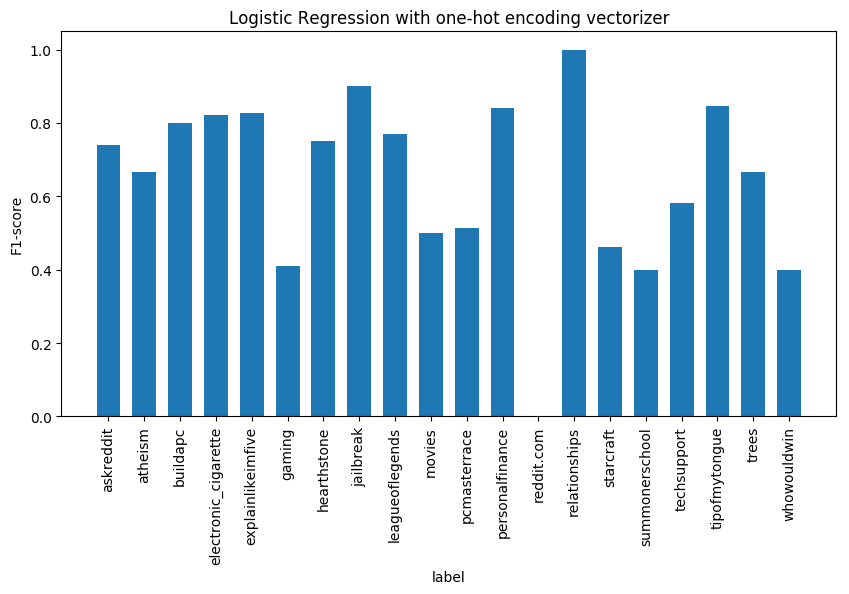

In [0]:
Logi = LogisticRegression(verbose=True)
print("Logi_countvectorizer_model")

Logi_countvectorizer_model = Logi.fit(countvectorizer_train_matrix,train_labels)

plt.figure(figsize=(10,5))

label = np.arange(len(fbeta_score(Logi_countvectorizer_model.predict(countvectorizer_test_matrix), test_labels,1,average=None)))
f1socre = fbeta_score(Logi_countvectorizer_model.predict(countvectorizer_test_matrix), test_labels ,1,average=None)
 


width = 1/1.5

plt.bar(label, f1socre,width)
plt.xticks(label, np.sort(np.unique(Logi_countvectorizer_model.predict(countvectorizer_test_matrix))),fontsize=10,rotation=90)
plt.ylabel('F1-score')
plt.xlabel('label')
plt.title('Logistic Regression with one-hot encoding vectorizer')

plt.show()

# Q2

**i) Parameter tuning. **

**Parameters of LogisticRegression**

In [0]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
c = [0.001,0.01,0.1, 1, 10, 100,1000,10000]
solver = ['newton-cg', 'lbfgs', 'sag', 'saga']
multi_class = ['ovr', 'multinomial']

lr_model = LogisticRegression(C=c, solver=solver, multi_class=multi_class)
param_grid= dict(C=c, solver= solver, multi_class= multi_class)

grid_search = GridSearchCV(estimator= lr_model, param_grid=param_grid, n_jobs=-1, verbose=1,scoring='f1_macro')
print("Performing grid search...")
print("parameters:")
print(param_grid)
grid_search.fit(tfidf_train_matrix, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted( param_grid.keys()):
  print("\t%s: %r" % ( param_name, best_parameters[ param_name]))

Performing grid search...
parameters:
{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 'multi_class': ['ovr', 'multinomial']}
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 11.6min finished


Best score: 0.656
Best parameters set:
	C: 10000
	multi_class: 'ovr'
	solver: 'saga'


**Vectorizer parameters**

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('vect',TfidfVectorizer(tokenizer=canonicalize)),
    ('clf', LogisticRegression(C= 10000,multi_class='ovr', solver= 'saga')),
])


parameters={
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,1), (1,2), (1,3)), 
    'vect__sublinear_tf': (True, False),
}

grid_search = GridSearchCV(pipeline, parameters, cv=5,
                               n_jobs=-1, verbose=1,scoring='f1_macro')

print("Performing grid search...")
print("parameters:")
print(parameters)
grid_search.fit(subreddit_train['body'], train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
parameters:
{'vect__max_features': (None, 5000, 10000, 50000), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3)), 'vect__sublinear_tf': (True, False)}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 44.9min finished


Best score: 0.646
Best parameters set:
	vect__max_features: 10000
	vect__ngram_range: (1, 1)
	vect__sublinear_tf: True


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('vect',TfidfVectorizer(tokenizer=canonicalize)),
    ('clf', LogisticRegression(C= 10000,multi_class='ovr', solver= 'saga')),
])


parameters={
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,1), (1,2), (1,3)), 
    'vect__sublinear_tf': (True, False),
}

grid_search = GridSearchCV(pipeline, parameters, cv=5,
                               n_jobs=-1, verbose=1,scoring='f1_macro')

print("Performing grid search...")
print("parameters:")
print(parameters)
grid_search.fit(subreddit_train['title'], train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
parameters:
{'vect__max_features': (None, 5000, 10000, 50000), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3)), 'vect__sublinear_tf': (True, False)}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.7min finished


Best score: 0.479
Best parameters set:
	vect__max_features: 10000
	vect__ngram_range: (1, 1)
	vect__sublinear_tf: False


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('vect',TfidfVectorizer(tokenizer=canonicalize_withoutstem)),
    ('clf', LogisticRegression(C= 10000,multi_class='ovr', solver= 'saga')),
])


parameters={
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,1), (1,2), (1,3)), 
    'vect__sublinear_tf': (True, False),
}

grid_search = GridSearchCV(pipeline, parameters, cv=5,
                               n_jobs=-1, verbose=1,scoring='f1_macro')

print("Performing grid search...")
print("parameters:")
print(parameters)
grid_search.fit(subreddit_train['authorId'], train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
parameters:
{'vect__max_features': (None, 5000, 10000, 50000), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3)), 'vect__sublinear_tf': (True, False)}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.2min finished


Best score: 0.378
Best parameters set:
	vect__max_features: 50000
	vect__ngram_range: (1, 1)
	vect__sublinear_tf: True


In [0]:
Logi = LogisticRegression(C= 10000,multi_class='ovr', solver= 'saga')
print("Logi_countvectorizer_model")


print("Logi_tfidf_model")
Logi_tfidf_model = Logi.fit(tfidf_train_matrix,train_labels)
eval_summary("Logi_countvectorizer_test_model", Logi_tfidf_model.predict(tfidf_test_matrix), test_labels)

Logi_countvectorizer_model
Logi_tfidf_model


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds

Confusion matrix:
 [[77  1  0  0  0  4  0  0  0  1  0  0  0  0  0  0  0  0  0  1]
 [ 3  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 32  0  0  0  0  0  0  0  2  0  0  0  0  0  1  0  0  1]
 [ 0  0  0  8  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    9.6s finished


In [0]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
# Use FeatureUnion to combine the features from text and summary
prediction_pipeline_tfidf=[]
prediction_pipeline_tfidf = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('authorId', Pipeline([
              ('selector', ItemSelector(key='authorId')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize_withoutstem,max_features=10000,ngram_range= (1, 1),sublinear_tf= True)), 
              ])),
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize,max_features=10000,ngram_range= (1, 1),sublinear_tf= False)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize,max_features=50000,ngram_range= (1, 1),sublinear_tf= True)), 
              ])),
        ])
        )
    ])

In [0]:
tfidf_train_matrix = prediction_pipeline_tfidf.fit_transform(subreddit_train)
tfidf_test_matrix = prediction_pipeline_tfidf.transform(subreddit_test)

In [0]:
Logi = LogisticRegression(C= 10000,multi_class='ovr', solver= 'saga')
print("Logi_countvectorizer_model")


print("Logi_tfidf_model")
Logi_tfidf_model = Logi.fit(tfidf_train_matrix,train_labels)
eval_summary("Logi_countvectorizer_test_model", Logi_tfidf_model.predict(tfidf_test_matrix), test_labels)

Logi_countvectorizer_model
Logi_tfidf_model

Confusion matrix:
 [[76  1  0  0  0  4  0  0  0  1  1  0  0  0  0  0  0  0  0  1]
 [ 4  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 33  0  0  0  0  0  0  0  1  0  0  0  0  0  1  0  0  1]
 [ 0  0  0  8  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  8  0  0  4  0  2  0  0  0  0  0  0  0  0  1]
 [ 2  0  0  0  0  1 11  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 46  0  1  0  0  0  0  0  1  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  5  0  0  3  0  0  0  0 10  0  0  0  0  0  3  0  0  1]
 [ 1  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  2  0  0  0  1  0  5  0  0  

In [0]:
Logi = LogisticRegression(verbose=True,C= 10000,multi_class='ovr', solver= 'saga')
print("Logi_countvectorizer_model")


print("Logi_tfidf_model")
Logi_tfidf_model = Logi.fit(tfidf_train_matrix,train_labels)
eval_summary("Logi_countvectorizer_test_model", Logi_tfidf_model.predict(tfidf_test_matrix), test_labels)

Logi_countvectorizer_model
Logi_tfidf_model


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds

Confusion matrix:
 [[77  1  0  0  0  4  0  0  0  1  0  0  0  0  0  0  0  0  0  1]
 [ 3  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 32  0  0  0  0  0  0  0  1  0  0  0  0  0  2  0  0  1]
 [ 0  0  0  8  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    9.0s finished


**Error analysis**

**Error analysis (ALL)**

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
# Pass in the tokenizer as the tokenizer to the vectorizer.
# Create a one-hot encoding vectorizer.

Logi = LogisticRegression(verbose=True,C= 10000,multi_class='ovr', solver= 'saga')

Logi_tfidf_model = Logi.fit(tfidf_train_matrix,train_labels)
pipe = make_pipeline(Logi)
pipe.score(tfidf_train_matrix, train_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    9.1s finished


1.0

In [0]:
Logi = LogisticRegression(verbose=True, C= 10000,	multi_class= 'ovr',	solver= 'saga')
Logi_tfidf_model = Logi.fit(tfidf_train_matrix,train_labels)
pipe = make_pipeline(Logi)
# pipe.score(tfidf_train_matrix, train_labels)
pipe.score(tfidf_test_matrix, test_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    9.3s finished


0.7835616438356164

In [0]:
eval_summary("Logi_countvectorizer_test_model", Logi_tfidf_model.predict(tfidf_test_matrix), test_labels)


Confusion matrix:
 [[76  1  0  0  0  4  0  0  0  1  1  0  0  0  0  0  0  0  0  1]
 [ 4  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 33  0  0  0  0  0  0  0  1  0  0  0  0  0  1  0  0  1]
 [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  8  0  0  4  0  2  0  0  0  0  0  0  0  0  1]
 [ 2  0  0  0  0  1 11  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 46  0  1  0  0  0  0  0  1  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  5  0  0  2  0  0  0  0 11  0  0  0  0  0  3  0  0  1]
 [ 1  0  0  0  0  0  0  0  0  0  0  8  0  1  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  2  0  0  0  1  0  5  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  3  0  0 

In [0]:
import pandas as pd

def print_errors(labels, predictions, data):
  label_arr = labels.values
  for idx, prediction in enumerate(predictions): 
    label = label_arr[idx]
    if prediction != label:
      print(idx, label, prediction, data.iloc[idx],"\n")

In [0]:
test_labels.head()

0        starcraft
1      whowouldwin
2        askreddit
3        askreddit
4    tipofmytongue
Name: subreddit, dtype: object

In [0]:
train_predictions = pipe.predict(tfidf_train_matrix)
test_predictions = pipe.predict(tfidf_test_matrix)

In [0]:
print_errors(test_labels, test_predictions, subreddit_test)

5 trees askreddit authorId    duel_dude Knotfloyd KuronekoKawaii vishnukg ra...
title       I Don't Understand Why People Hate the War On ...
body        I think they make pretty good music: https://w...
Name: 5, dtype: object 

9 hearthstone leagueoflegends authorId                             Orconem Hjelpen wpScraps
title                   Undocumented change: Stall prevention
body        So I meant to post this yesterday, but in one ...
Name: 9, dtype: object 

12 atheism askreddit authorId    Character_T Viin etbob623 shazang zzorga Pseud...
title                                Fear No Evil [wallpaper]
body         Inspirational. I must not fear.\n\nFear is th...
Name: 12, dtype: object 

16 buildapc askreddit authorId      twoscoop BuffaloLP twoscoop JaxXx_oL20 twoscoop
title                     Router kicking people off internet.
body        Is it possible that my dual band network card ...
Name: 16, dtype: object 

17 reddit.com askreddit authorId                       playplay

**Error analysis(authorID)**

In [0]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
# Use FeatureUnion to combine the features from text and summary
prediction_pipeline_tfidf=[]
prediction_pipeline_tfidf = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('authorId', Pipeline([
              ('selector', ItemSelector(key='authorId')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize_withoutstem,max_features=10000,ngram_range= (1, 1),sublinear_tf= True)), 
              ])),
        ])
        )
    ])

# Create a TfidfVectorize.
# tfidf_vectorizer = TfidfVectorizer(tokenizer=canonicalize)
tfidf_train_matrix_authorId = prediction_pipeline_tfidf.fit_transform(subreddit_train)
tfidf_test_matrix_authorId = prediction_pipeline_tfidf.transform(subreddit_test)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
# Pass in the tokenizer as the tokenizer to the vectorizer.
# Create a one-hot encoding vectorizer.

Logi = LogisticRegression(verbose=True, C= 10000,	multi_class= 'ovr',	solver= 'saga')

Logi_tfidf_model = Logi.fit(tfidf_train_matrix_authorId,train_labels)
pipe = make_pipeline(Logi)
# pipe.score(tfidf_train_matrix_authorId, train_labels)
# 0.9979395604395604
pipe.score(tfidf_test_matrix_authorId, test_labels)
# 0.4191780821917808

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.7s finished


0.9979395604395604

In [0]:
import pandas as pd

def print_errors(labels, predictions, data):
  label_arr = labels.values
  for idx, prediction in enumerate(predictions): 
    label = label_arr[idx]
    if prediction != label:
      print(idx, label, prediction, data.iloc[idx]['authorId'],"\n")
print_errors(test_labels, test_predictions, subreddit_test)

5 trees askreddit duel_dude Knotfloyd KuronekoKawaii vishnukg randooooom vishnukg Briansama gaahl666 MasterofPandas1 srekcornaivaf Defazioyo 

9 hearthstone leagueoflegends Orconem Hjelpen wpScraps 

12 atheism askreddit Character_T Viin etbob623 shazang zzorga PseudoMcJudo Roryrooster 258joe007 twitch1982 osgrug Golemfrost jakeross Sumogon 

16 buildapc askreddit twoscoop BuffaloLP twoscoop JaxXx_oL20 twoscoop 

17 reddit.com askreddit playplayplay Dagon AngledLuffa 

31 reddit.com askreddit mutatron MrFlesh VoodooIdol VoodooIdol lavendula13 

34 hearthstone askreddit hiAnxiety MyOtherCarIsACdr hiAnxiety MyOtherCarIsACdr HSWannaBe osborn89419 hiAnxiety osborn89419 reddittarded hiAnxiety skutbag HINDBRAIN 

37 summonerschool leagueoflegends Maverick101Gr Evilon superior22 Tikkariz MicBrrravo KingHalfrican alucardcanidae 

48 pcmasterrace buildapc santossrv santossrv 

49 askreddit pcmasterrace SancteAmbrosi Rocket25 FUCKCOST a-brown-bear 

54 reddit.com askreddit BeGayOkay -Borfo- chee

In [0]:
eval_summary("Logi_countvectorizer_test_model", Logi_tfidf_model.predict(tfidf_test_matrix_authorId), test_labels)


Confusion matrix:
 [[80  0  0  0  1  0  0  0  0  0  0  0  2  0  0  0  0  0  1  0]
 [ 7  4  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [23  0 12  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0]
 [ 5  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [11  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [13  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  0  0  0  0  2  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [33  0  0  0  0  0  1  0 13  0  0  0  0  0  0  1  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0]
 [17  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0]
 [ 6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  0  0  0  0  0  1  0  0  0  0  0  0  1  2  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0  0  0 

**Error analysis(title)**

In [0]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
# Use FeatureUnion to combine the features from text and summary
prediction_pipeline_tfidf = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
           ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize,max_features=10000,ngram_range= (1, 1),sublinear_tf= False)), 
              ])),
        ])
        )
    ])
# Create a TfidfVectorize.
# tfidf_vectorizer = TfidfVectorizer(tokenizer=canonicalize)
tfidf_train_matrix_title = prediction_pipeline_tfidf.fit_transform(subreddit_train)
tfidf_test_matrix_title = prediction_pipeline_tfidf.transform(subreddit_test)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
# Pass in the tokenizer as the tokenizer to the vectorizer.
# Create a one-hot encoding vectorizer.

Logi = LogisticRegression(verbose=True, C= 1000,	multi_class= 'ovr',	solver= 'saga')

Logi_tfidf_model = Logi.fit(tfidf_train_matrix_title,train_labels)
pipe = make_pipeline(Logi)
pipe.score(tfidf_train_matrix_title, train_labels)
# 0.9993131868131868
pipe.score(tfidf_test_matrix_title, test_labels)
# 0.5534246575342465

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished


0.5534246575342465

In [0]:
eval_summary("Logi_countvectorizer_test_model", Logi_tfidf_model.predict(tfidf_test_matrix_title), test_labels)


Confusion matrix:
 [[60  2  2  0  0  3  0  0  5  2  2  1  2  2  1  0  0  0  0  2]
 [ 4  4  1  0  0  0  0  0  0  0  1  0  2  0  0  0  0  0  0  0]
 [ 2  0 30  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  1]
 [ 0  1  1  3  0  0  0  0  1  0  1  0  0  0  0  0  1  0  1  0]
 [ 1  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  5  1  0  1  1  4  0  0  0  0  0  0  0  2  1]
 [ 4  0  1  0  0  3  3  0  2  0  1  0  0  0  0  0  0  0  1  0]
 [ 3  0  0  0  0  0  1  4  1  0  0  0  0  0  0  1  1  0  0  0]
 [ 3  1  0  1  0  3  2  1 28  0  2  1  0  2  0  1  2  0  1  0]
 [ 1  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0]
 [ 3  0  3  0  0  3  1  0  3  0  3  0  1  0  0  0  5  0  0  1]
 [ 4  0  1  0  0  0  0  0  0  0  0  3  0  1  0  0  1  0  0  0]
 [ 3  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  2  0  0  0  2  0  1  0  0  0  0  1]
 [ 1  0  0  0  0  0  0  0  2  0  0 

In [0]:
import pandas as pd

def print_errors(labels, predictions, data):
  label_arr = labels.values
  for idx, prediction in enumerate(predictions): 
    label = label_arr[idx]
    if prediction != label:
      print(idx, label, prediction, data.iloc[idx]['title'],"\n")
print_errors(test_labels, test_predictions, subreddit_test)

5 trees askreddit I Don't Understand Why People Hate the War On Drugs So much. 

9 hearthstone leagueoflegends Undocumented change: Stall prevention 

12 atheism askreddit Fear No Evil [wallpaper] 

16 buildapc askreddit Router kicking people off internet. 

17 reddit.com askreddit Ask Reddit: i am somewhat overweight, i want to run high school track. I need an exercise regimen that wont take t 

31 reddit.com askreddit Question:  Is there a douchebag that downmods every submission?  I cannot find a single submission of mine that does not have one single downmod. 

34 hearthstone askreddit [Serious] Hi... Is anyone else seriously addicted to this game? 

37 summonerschool leagueoflegends Kha'Zix 4.9 

48 pcmasterrace buildapc Quick question 

49 askreddit pcmasterrace Guys, what guy are you? 

54 reddit.com askreddit I have decided to raise my child to be gay. (it IS a choice) 

59 pcmasterrace askreddit Giving away COD World At War CD Key (Not a digital one) 

60 personalfinance askre

**Error analysis(body)**

In [0]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
# Use FeatureUnion to combine the features from text and summary
prediction_pipeline_tfidf = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize,max_features=50000,ngram_range= (1, 1),sublinear_tf= True)), 
              ])),
        ])
        )
    ])
# Create a TfidfVectorize.
# tfidf_vectorizer = TfidfVectorizer(tokenizer=canonicalize)
tfidf_train_matrix_body = prediction_pipeline_tfidf.fit_transform(subreddit_train)
tfidf_test_matrix_body = prediction_pipeline_tfidf.transform(subreddit_test)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
# Pass in the tokenizer as the tokenizer to the vectorizer.
# Create a one-hot encoding vectorizer.

Logi = LogisticRegression(verbose=True, C= 10000,	multi_class= 'ovr',	solver= 'saga')

Logi_tfidf_model = Logi.fit(tfidf_train_matrix_body,train_labels)
pipe = make_pipeline(Logi)
# pipe.score(tfidf_train_matrix_body, train_labels)
# 1.0
pipe.score(tfidf_test_matrix_body, test_labels)
# 0.726027397260274

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.9s finished


0.726027397260274

In [0]:
import pandas as pd

def print_errors(labels, predictions, data):
  label_arr = labels.values
  for idx, prediction in enumerate(predictions): 
    label = label_arr[idx]
    if prediction != label:
      print(idx, label, prediction, data.iloc[idx]['body'],"\n")
print_errors(test_labels, test_predictions, subreddit_test)

5 trees askreddit I think they make pretty good music: https://www.youtube.com/watch?v=TZ9IXScip68&list=PLZqsyBiYZFQ2zWQNnDpo7mud9SNB4W5wc&index=1 Beautiful music. This whole album is great. Saw this coming, still laughed. Awesome album Ohhh my god dude, In my head I compiled a list of all the things that are wrong with the war on drugs and freedom country in general and then I was just amazed by the music.... Incredible live and high  I just realized how stupidly argumentative I am. I came here with a list a mile long, only to crack a smile and feel foolish. Thanks for the dose of humility OP, haha.  Dude, that is luxury.  Yeah, I was pretty lucky to stumble across that experience. It happened though cause I needed to sit down after raging so hard for ILOVEMAKONNEN haha.  Fucking great song man, love this band nice to see them on here I hate you now.  

9 hearthstone leagueoflegends So I meant to post this yesterday, but in one of my Arena games I noticed something I hadn't seen befor

**Error analysis(authorID+title)**

In [0]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
# Use FeatureUnion to combine the features from text and summary
prediction_pipeline_tfidf = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('authorId', Pipeline([
              ('selector', ItemSelector(key='authorId')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize_withoutstem,max_features=10000,ngram_range= (1, 1),sublinear_tf= True)), 
              ])),
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize,max_features=10000,ngram_range= (1, 1),sublinear_tf= False)), 
              ])),
        ])
        )
    ])
# Create a TfidfVectorize.
# tfidf_vectorizer = TfidfVectorizer(tokenizer=canonicalize)
tfidf_train_matrix_authorid_title = prediction_pipeline_tfidf.fit_transform(subreddit_train)
tfidf_test_matrix_authorid_title = prediction_pipeline_tfidf.transform(subreddit_test)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
# Pass in the tokenizer as the tokenizer to the vectorizer.
# Create a one-hot encoding vectorizer.

Logi = LogisticRegression(verbose=True, C= 1000,	multi_class= 'ovr',	solver= 'saga')

Logi_tfidf_model = Logi.fit(tfidf_train_matrix_authorid_title,train_labels)
pipe = make_pipeline(Logi)
# pipe.score(tfidf_train_matrix_authorid_title, train_labels)
# 1.0
pipe.score(tfidf_test_matrix_authorid_title, test_labels)
# 0.6301369863013698

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.0s finished


0.6438356164383562

In [0]:
import pandas as pd

def print_errors(labels, predictions, data):
  label_arr = labels.values
  for idx, prediction in enumerate(predictions): 
    label = label_arr[idx]
    if prediction != label:
      print(idx, label, prediction, data.iloc[idx],"\n")
print_errors(test_labels, test_predictions, subreddit_test)

5 trees askreddit authorId    duel_dude Knotfloyd KuronekoKawaii vishnukg ra...
title       I Don't Understand Why People Hate the War On ...
body        I think they make pretty good music: https://w...
Name: 5, dtype: object 

9 hearthstone leagueoflegends authorId                             Orconem Hjelpen wpScraps
title                   Undocumented change: Stall prevention
body        So I meant to post this yesterday, but in one ...
Name: 9, dtype: object 

12 atheism askreddit authorId    Character_T Viin etbob623 shazang zzorga Pseud...
title                                Fear No Evil [wallpaper]
body         Inspirational. I must not fear.\n\nFear is th...
Name: 12, dtype: object 

16 buildapc askreddit authorId      twoscoop BuffaloLP twoscoop JaxXx_oL20 twoscoop
title                     Router kicking people off internet.
body        Is it possible that my dual band network card ...
Name: 16, dtype: object 

17 reddit.com askreddit authorId                       playplay

**Error analysis(title+body)**

In [0]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
# Use FeatureUnion to combine the features from text and summary
prediction_pipeline_tfidf = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize,max_features=10000,ngram_range= (1, 1),sublinear_tf= False)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize,max_features=50000,ngram_range= (1, 1),sublinear_tf= True)), 
              ])),
        ])
        )
    ])
# Create a TfidfVectorize.
# tfidf_vectorizer = TfidfVectorizer(tokenizer=canonicalize)
tfidf_train_matrix_title_body = prediction_pipeline_tfidf.fit_transform(subreddit_train)
tfidf_test_matrix_title_body = prediction_pipeline_tfidf.transform(subreddit_test)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
# Pass in the tokenizer as the tokenizer to the vectorizer.
# Create a one-hot encoding vectorizer.

Logi = LogisticRegression(verbose=True, C= 1000,	multi_class= 'ovr',	solver= 'saga')

Logi_tfidf_model = Logi.fit(tfidf_train_matrix_title_body,train_labels)
pipe = make_pipeline(Logi)
pipe.score(tfidf_train_matrix_title_body, train_labels)
# 1.0
pipe.score(tfidf_test_matrix_title_body, test_labels)
# 0.7534246575342466

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    8.5s finished


0.7534246575342466

**Error analysis(authorID+body)**

In [0]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
# Use FeatureUnion to combine the features from text and summary
prediction_pipeline_tfidf = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('authorId', Pipeline([
              ('selector', ItemSelector(key='authorId')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize_withoutstem,max_features=10000,ngram_range= (1, 1),sublinear_tf= True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize,max_features=50000,ngram_range= (1, 1),sublinear_tf= True)), 
              ])),
        ])
        )
    ])
# Create a TfidfVectorize.
# tfidf_vectorizer = TfidfVectorizer(tokenizer=canonicalize)
tfidf_train_matrix_authorId_body = prediction_pipeline_tfidf.fit_transform(subreddit_train)
tfidf_test_matrix_authorId_body = prediction_pipeline_tfidf.transform(subreddit_test)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
# Pass in the tokenizer as the tokenizer to the vectorizer.
# Create a one-hot encoding vectorizer.

Logi = LogisticRegression(verbose=True, C= 1000,	multi_class= 'ovr',	solver= 'saga')

Logi_tfidf_model = Logi.fit(tfidf_train_matrix_authorId_body,train_labels)
pipe = make_pipeline(Logi)
# pipe.score(tfidf_train_matrix_authorId_body, train_labels)
# 1.0
pipe.score(tfidf_test_matrix_authorId_body, test_labels)
# 0.7315068493150685

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    8.6s finished


0.7315068493150685

Logi_tfidf_model
[LibLinear]
Confusion matrix:
 [[78  0  0  0  0  4  0  0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 4  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 33  0  0  0  0  0  0  0  1  0  0  0  0  0  1  0  0  1]
 [ 0  0  0  8  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  9  0  0  4  0  2  0  0  0  0  0  0  0  0  1]
 [ 2  0  0  0  0  1 11  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0 44  0  1  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  5  0  0  1  0  0  1  0 11  0  0  0  0  0  3  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  9  0  1  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 2  0  0  1  0  0  0  0  1  0  0  0  1  0  4  0  0  0  0  1]
 [ 0  0

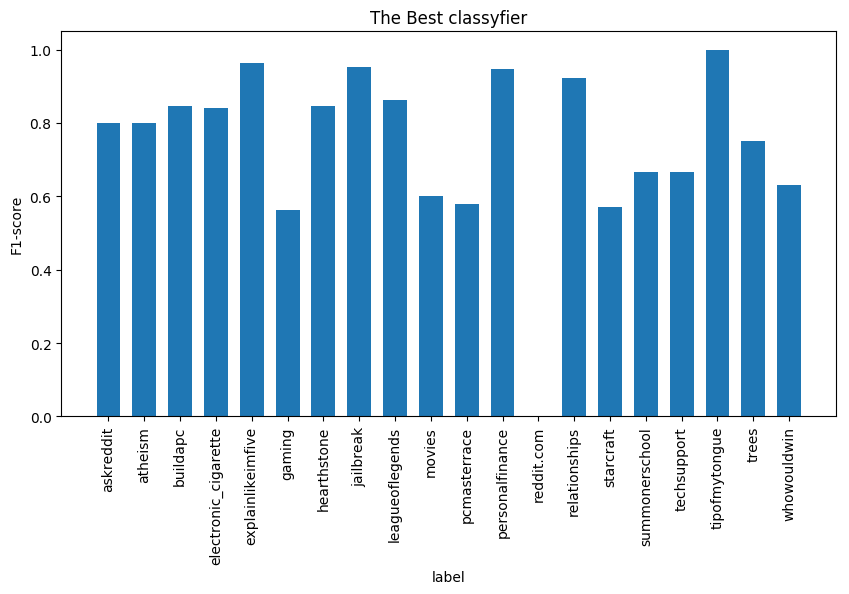

[0.8        0.8        0.84615385 0.84210526 0.96296296 0.5625
 0.84615385 0.95238095 0.8627451  0.6        0.57894737 0.94736842
 0.         0.92307692 0.57142857 0.66666667 0.66666667 1.
 0.75       0.63157895]
LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=True, warm_start=False)


In [0]:
print("Logi_tfidf_model")
Logi = LogisticRegression(verbose=True, C=10000)
Logi_tfidf_model = Logi.fit(tfidf_train_matrix,train_labels)
eval_summary("Logi_countvectorizer_test_model", Logi_tfidf_model.predict(tfidf_test_matrix), test_labels)
plt.figure(figsize=(10,5))

label = np.arange(len(fbeta_score(Logi_tfidf_model.predict(tfidf_test_matrix), test_labels,1,average=None)))
f1socre = fbeta_score(Logi_tfidf_model.predict(tfidf_test_matrix), test_labels ,1,average=None)
 


width = 1/1.5

plt.bar(label, f1socre,width)
plt.xticks(label, np.sort(np.unique(Logi_tfidf_model.predict(tfidf_test_matrix))),fontsize=10,rotation=90)
plt.ylabel('F1-score')
plt.xlabel('label')
plt.title('The Best classyfier')

plt.show()

# Classifier 'Logi_countvectorizer_test_model' has P=0.659 R=0.742 Acc=0.740 F1=0.682
# Best score: 0.736
# Best parameters set:
# 	clf__C: 10000
# 	vect__max_features: None
# 	vect__ngram_range: (1, 1)
# 	vect__sublinear_tf: True

print(f1socre)
print(Logi_tfidf_model)

# (iiI) feature development

**Length of posts**

In [0]:
np.shape(train_threads)
# train_threads

(1456, 5)

In [0]:
subreddit_train_F1=[]
subreddit_train_new=[]
collabels=[]
for count in range(len(subreddit_train)):
  subreddit_train_new.append( (subreddit_train['title'][count], subreddit_train['authorId'][count],subreddit_train['body'][count], str(len(train_threads['posts'][count])/len(train_threads))))
  collabels = ['title', 'authorId', 'body', 'post/thread_length']
  subreddit_train_F1 = pd.DataFrame(subreddit_train_new, columns=collabels)
  
subreddit_test_F1=[]
subreddit_test_new=[]
collabels=[]
for count in range(len(subreddit_test)):
  subreddit_test_new.append( (subreddit_test['title'][count], subreddit_test['authorId'][count],subreddit_test['body'][count], str(len(test_threads['posts'][count])/len(test_threads))))
  collabels = ['title', 'authorId', 'body', 'post/thread_length']
  subreddit_test_F1 = pd.DataFrame(subreddit_test_new, columns=collabels)

**Word embedding feature**

In [0]:
local_file = "glove.6B.200d_gensim.txt.gz"
!gsutil cp  gs://textasdata/glove.6B.200d_gensim.txt.gz $local_file 

Copying gs://textasdata/glove.6B.200d_gensim.txt.gz...
- [1 files][252.1 MiB/252.1 MiB]                                                
Operation completed over 1 objects/252.1 MiB.                                    


In [0]:
#!pip install 'gensim==3.2.0'
!pip install --upgrade gensim


    100% |████████████████████████████████| 24.2MB 1.8MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [0]:
from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("glove.6B.200d_gensim.txt.gz")

In [0]:
# Solution 
def word_analogy(word_a, word_b, word_c, k=5):
    """
    Function that solves problem analogy word_a to word_b = word_c to ?
    @param word_a, word_b, word_c: string
    @param k: top k candidates to return
    """
    positive_words = [word_a, word_c]
    negative_words = [word_b]
    return glove_model.most_similar(positive=positive_words, negative=negative_words, topn=k)

In [0]:
import numpy as np

def doesnt_match(words):
  filtered_words = [word for word in words if word in glove_model]
  vectors = [glove_model.word_vec(word, use_norm=True) for word in filtered_words]
  mean = np.mean(vectors, axis=0)
  distances = glove_model.cosine_similarities(mean, vectors)
  return sorted(zip(distances, filtered_words))[0][1]

In [0]:
# subreddit_train['body']
import itertools
all_tokens_train = []
all_posts_tokenized_train = subreddit_train.body.apply(tokenize_normalize)
all_tokens_train = list(itertools.chain.from_iterable(all_posts_tokenized_train))
print("Num tokens: ", len(all_tokens_train))

# subreddit_test['body']
import itertools
all_tokens_test = []
all_posts_tokenized_test = subreddit_test.body.apply(tokenize_normalize)
all_tokens_test = list(itertools.chain.from_iterable(all_posts_tokenized_test))
print("Num tokens: ", len(all_tokens_test))

Num tokens:  552283
Num tokens:  143915


In [0]:
#Solution

import gensim
import time

t0 = time.time()
model_train = gensim.models.Word2Vec(all_posts_tokenized_train, size=50, window=5, \
                               min_count=5, sg=0, alpha=0.025, iter=10, batch_words=10000)
print ("done in %.02f s" % (time.time() - t0))

model_test = gensim.models.Word2Vec(all_posts_tokenized_test, size=50, window=5, \
                               min_count=5, sg=0, alpha=0.025, iter=10, batch_words=10000)
print ("done in %.02f s" % (time.time() - t0))

done in 6.80 s
done in 8.46 s


In [0]:
from sklearn.base import BaseEstimator

class Estimator(BaseEstimator):

    def fit(self, X, y=None):
        """
        Accept input data, X, and optional target data, y. Returns self.
        """
        return self

    def predict(self, X):
        """
        Accept input data, X and return a vector of predictions for each row.
        """
        return yhat
      
from sklearn.base import TransformerMixin

class Transfomer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        """
        Learn how to transform data based on input data, X.
        """
        return self

    def transform(self, X):
        """
        Transform X into a new dataset, Xprime and return it.
        """
        return Xprime

In [0]:
#Solution
import numpy as np

from sklearn.base import BaseEstimator


class AverageEmbeddingVectorizer(BaseEstimator):
    def __init__(self, embedding_model):
        self.embedding = embedding_model
        self.dimension = embedding_model.vector_size

    def fit(self, X, y):
        return self
      
    def transform(self, X):  
      # Skip OOV terms. Return 0 if no words are in the vocabulary.
      #print (X)
      return np.array([ 
          np.mean([self.embedding[token] for token in doc if token in self.embedding]
                or [np.zeros(self.dimension)], axis=0)
          for doc in X
      ])

In [0]:
reddit_vectorizer_train = AverageEmbeddingVectorizer(model_train)
reddit_vectorizer_test = AverageEmbeddingVectorizer(model_test)
glove_vectorizer = AverageEmbeddingVectorizer(glove_model)

In [0]:
doc = tokenize_normalize('watch the cat chase the dog')
X = [doc]
print("Glove:")
print(glove_vectorizer.transform(X))
print("Reddit:")
print(reddit_vectorizer_train.transform(X))
print(reddit_vectorizer_test.transform(X))

Glove:
[[ 1.63113698e-01 -1.24406993e-01 -2.57880479e-01 -2.96022981e-01
  -1.29645661e-01 -7.15244338e-02 -4.49286669e-01 -4.48928215e-02
  -5.03983349e-02  6.87483326e-03  1.11675680e-01 -4.64133322e-02
   7.09949955e-02  1.03816658e-01  1.17365003e-01 -2.29881659e-01
  -2.09559992e-01  3.26450378e-01 -2.05681667e-01  1.63859665e-01
   1.66395500e-01  1.89386165e+00  4.32740360e-01 -1.79530323e-01
   5.37426658e-02 -2.50137657e-01  1.44816652e-01  6.11399896e-02
  -9.75496173e-02 -1.12716168e-01  1.23511672e-01  2.49949992e-02
  -5.09999990e-02 -3.18212181e-01  1.47144005e-01 -3.21818322e-01
  -4.75318521e-01 -3.23068388e-02 -2.82053351e-02 -2.19905213e-01
   7.86913335e-02  3.43749970e-02  1.87430084e-02  5.25139987e-01
  -1.93519652e-01  6.71821654e-01  5.02445042e-01 -8.71263370e-02
   2.69181490e-01  4.74094152e-01 -1.04417168e-01  9.11586657e-02
   2.13824019e-01 -7.50293210e-02  4.01116647e-02 -3.11411116e-02
  -2.57424980e-01  1.16599999e-01 -1.16294362e-01  2.63558298e-01
   

In [0]:
glove_post_vector_matrix_train = glove_vectorizer.transform(all_posts_tokenized_train)
glove_post_vector_matrix_test = glove_vectorizer.transform(all_posts_tokenized_test)
reddit_post_vector_matrix_train = reddit_vectorizer_train.transform(all_posts_tokenized_train)
reddit_post_vector_matrix_test = reddit_vectorizer_test.transform(all_posts_tokenized_test)

In [0]:
import gensim
import collections
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tagged_documents_train = [TaggedDocument(words=_d, tags=[i]) for i, _d in enumerate(all_posts_tokenized_train)]
tagged_documents_test = [TaggedDocument(words=_d, tags=[i]) for i, _d in enumerate(all_posts_tokenized_test)]
# In the paper they use 400 as the dimensions, may take many more epochs to converge.
# The devil is in the details to make these work effectively.
d2v_model_train = gensim.models.doc2vec.Doc2Vec(tagged_documents_train, vector_size=300, alpha=0.025, min_alpha=0.001, min_count=5, window=8, epochs=10)
d2v_model_test = gensim.models.doc2vec.Doc2Vec(tagged_documents_test, vector_size=300, alpha=0.025, min_alpha=0.001, min_count=5, window=8, epochs=10)
# vocab = collections.Counter(all_tokens)
# d2v_model.build_vocab_from_freq(vocab)


In [0]:
Word_embedding_features_train=list()
for count in range(len(tagged_documents_train)):
  if tagged_documents_train[count] is not None:
    Word_embedding_features_train.append((' '.join(tagged_documents_train[count][0])))
   
# Word_embedding_features

Word_embedding_features_test=list()
for count in range(len(tagged_documents_test)):
  if tagged_documents_test[count] is not None:
    Word_embedding_features_test.append((' '.join(tagged_documents_test[count][0])))
 


In [0]:
Word_embedding_features_test[0]

'was watching a vod from last years dreamhack winter the first map in the finals naama vs mana was lost temple spawning close ground positions it a great sign that shows how much the game is evolving imo has anyone else noticed stuff like this i find it cool that both mana and naama made it to the in this dh winter shows that they were just flashes in the pan even better watch a vod from mlg vs nadagast steppes of war mlg raleigh the games the casting the maps everything was fucking awful amazing that it was just over one year ago was that also an epic and awesome series i remember it being one of the best series i had seen at that point'

In [0]:
subreddit_train_F2=[]
subreddit_train_new=[]
collabels=[]
for count in range(len(subreddit_train)):
  subreddit_train_new.append( (subreddit_train['title'][count], subreddit_train['authorId'][count],subreddit_train['body'][count], subreddit_train_F1['post/thread_length'][count],Word_embedding_features_train[count]))
  collabels = ['title', 'authorId', 'body', 'post/thread_length', 'Word_embedding']
  subreddit_train_F2 = pd.DataFrame(subreddit_train_new, columns=collabels)
  
subreddit_test_F2=[]
subreddit_test_new=[]
collabels=[]
for count in range(len(subreddit_test)):
  subreddit_test_new.append( (subreddit_test['title'][count], subreddit_test['authorId'][count],subreddit_test['body'][count],subreddit_test_F1['post/thread_length'][count], Word_embedding_features_test[count]))
  collabels = ['title', 'authorId', 'body','post/thread_length', 'Word_embedding']
  subreddit_test_F2 = pd.DataFrame(subreddit_test_new, columns=collabels)

In [0]:
subreddit_train_F2.head()

title  \
0  How do I [23F] communicate with my self-center...   
1  What Cherry switch do you recommend for League...   
2                   Where do memes go when they die?   
3                     Some weird long term affects??   
4  Simple question: If I install Windows to a sta...   

                                            authorId  \
0  Pouritdownmythroat WhyFrankWhy Pouritdownmythr...   
1  ThisGermanGuy shaunrnm Sub_Salac MisterBlack8 ...   
2  Leisure321 Zeolance Buttersgoo23 quzimaa Escap...   
3     refugee4chan donquixote6179 ThatStonedAsianGuy   
4           catalyzeme uses rvabdn greg2709 spydr101   

                                                body     post/thread_length  \
0  I think everyone has that one friend who loves...   0.004807692307692308   
1  I not 100% sure this is the right place to pos...   0.005494505494505495   
2   Facebook 9gag Memes never truly die Dickbutt ...   0.006868131868131868   
3  It's called 'forgetting things'. Dude i dont t...  0.0020604395604395605   
4  How would I do this? I am looking to wait anot...   0.003434065934065934   

                                      Word_embedding  
0  i think everyone has that one friend who loves...  
1  i not 100 sure this is the right place to post...  
2  facebook memes never truly die dickbutt memes ...  
3  it called forgetting things dude i do nt think...  
4  how would i do this i am looking to wait anoth...

In [0]:
subreddit_test_F2.head()


title  \
0  Just a reminder on how much SC2 has evolved th...   
1  Your Favorite Hero Now Has A Healing Factor As...   
2  If you could live anywhere in the world, where...   
3                   Do you ever get use to exercise?   
4         [TOMT] [book] A scary french book for kids   

                                            authorId  \
0                    MeisterKarl smsy vehemus NruJaC   
1  TheAnti-Monitor iamcatch22 blames_irrationally...   
2  Daft-Punk AutoModerator Memithezombiekiller Im...   
3  theawe_some DrWallyHayes IGrammarGood theawe_s...   
4                                      grapesandmilk   

                                                body    post/thread_length  \
0  Was watching a VOD from last years DreamHack W...  0.010958904109589041   
1  Basically what the title says. Danny Phantom i...    0.0547945205479452   
2   On a beach someplace warm and far away from a...  0.021917808219178082   
3  I start running this year. I do it frequently ...  0.021917808219178082   
4  [deleted] Could you possibly provide us a clue...   0.01643835616438356   

                                      Word_embedding  
0  was watching a vod from last years dreamhack w...  
1  basically what the title says danny phantom is...  
2  on a beach someplace warm and far away from an...  
3  i start running this year i do it frequently n...  
4  deleted could you possibly provide us a clue w...

In [0]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
# Use FeatureUnion to combine the features from text and summary
prediction_pipeline_tfidf_F1=[]
prediction_pipeline_tfidf_F1 = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('authorId', Pipeline([
              ('selector', ItemSelector(key='authorId')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize_withoutstem,max_features=10000,ngram_range= (1, 1),sublinear_tf= True)), 
              ])),
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize,max_features=10000,ngram_range= (1, 1),sublinear_tf= False)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize,max_features=50000,ngram_range= (1, 1),sublinear_tf= True)), 
              ])),
            ('post/thread_length', Pipeline([
              ('selector', ItemSelector(key='post/thread_length')),
              ('TF-IDF', TfidfVectorizer()), 
              ])),
            ('Word_embedding', Pipeline([
              ('selector', ItemSelector(key='Word_embedding')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize)), 
              ])),
        ])
        )
    ])

In [0]:
# Create a TfidfVectorize.
# tfidf_vectorizer = TfidfVectorizer(tokenizer=canonicalize)
tfidf_train_matrix_F1=[]
tfidf_test_matrix_F1=[]
tfidf_train_matrix_F1 = prediction_pipeline_tfidf_F1.fit_transform(subreddit_train_F2)
tfidf_test_matrix_F1 = prediction_pipeline_tfidf_F1.transform(subreddit_test_F2)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
# Pass in the tokenizer as the tokenizer to the vectorizer.
# Create a one-hot encoding vectorizer.

Logi = LogisticRegression(verbose=True, C= 10000,	multi_class= 'ovr',	solver= 'saga')

Logi_tfidf_model = Logi.fit(tfidf_train_matrix_F1,train_labels)
pipe = make_pipeline(Logi)
pipe.score(tfidf_train_matrix_F1, train_labels)
# 1.0
pipe.score(tfidf_test_matrix_F1, test_labels)
# 0.7808219178082192 Classifier 'Logi_countvectorizer_test_model' has P=0.716 R=0.806 Acc=0.784 F1=0.742
# 0.7780821917808219 F1 Classifier 'Logi_countvectorizer_test_model' has P=0.747 R=0.739 Acc=0.778 F1=0.729
# 0.7945205479452054 F2 Classifier 'Logi_countvectorizer_test_model' has P=0.724 R=0.824 Acc=0.795 F1=0.749
# 0.7972602739726027 F1+F2 Classifier 'Logi_countvectorizer_test_model' has P=0.762 R=0.771 Acc=0.797 F1=0.754

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   16.4s finished


0.7972602739726027

In [0]:
eval_summary("Logi_countvectorizer_test_model", Logi_tfidf_model.predict(tfidf_test_matrix_F1), test_labels)


Confusion matrix:
 [[69  2  0  0  1  4  0  0  1  1  0  1  1  2  0  0  0  1  0  1]
 [ 2 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 34  0  0  0  0  0  0  0  1  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0 11  0  0  1  0  2  0  0  0  0  0  1  0  0  1]
 [ 1  0  0  0  0  2 11  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0 45  0  1  0  0  0  0  0  1  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  7  0  0  3  0  0  0  0  9  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  9  0  1  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  1  0  6  1  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  2  0  0 

## Part B: Discourse prediction ##

In [10]:
discourse_train = "coursework_discourse_train.json"
discourse_test = "coursework_discourse_test.json"
  
!gsutil cp gs://textasdata/coursework/coursework_discourse_train.json $discourse_train  
!gsutil cp gs://textasdata/coursework/coursework_discourse_test.json  $discourse_test

Copying gs://textasdata/coursework/coursework_discourse_train.json...
| [1 files][ 60.2 MiB/ 60.2 MiB]                                                
Operation completed over 1 objects/60.2 MiB.                                     
Copying gs://textasdata/coursework/coursework_discourse_test.json...
\ [1 files][ 15.1 MiB/ 15.1 MiB]                                                
Operation completed over 1 objects/15.1 MiB.                                     


In [0]:
# The reddit thread structure is nested with posts in a new content.
# This block reads the file as json and creates a new data frame.
import pandas as pd
import json

def load_posts(file):
  # A temporary variable to store the list of post content.
  posts_tmp = list()

  with open(file) as jsonfile:
    for i, line in enumerate(jsonfile):
     # if (i > 2): break
      thread = json.loads(line)
      for post in thread['posts']:
        # NOTE: This could be changed to use additional features from the post or thread.
        # DO NOT change the labels for the test set.
        posts_tmp.append((thread['subreddit'], thread['title'], thread['url'],
                        post['id'], post.get('author', ""), post.get('body', ""), post.get("majority_link", ""), 
                        post.get('post_depth', 0), post.get('majority_type', ""), # discourse type label 
                        post.get('in_reply_to', "") ))

# Create the posts data frame.  
  labels = ['subreddit', 'title', 'url', 'id', 'author', 'body', 'majority_link', 
          'post_depth', 'discourse_type', 'in_reply_to']
  return pd.DataFrame(posts_tmp, columns=labels)

In [12]:
train_posts = load_posts(discourse_train)
# Filter out empty labels
train_posts = train_posts[train_posts['discourse_type'] != ""]
print(train_posts.head())
print("Num posts: ", train_posts.size)

    subreddit                           title  \
0  worldofpvp  Help me decide my new PvP main   
1  worldofpvp  Help me decide my new PvP main   
2  worldofpvp  Help me decide my new PvP main   
3  worldofpvp  Help me decide my new PvP main   
4  worldofpvp  Help me decide my new PvP main   

                                                 url          id  \
0  https://www.reddit.com/r/worldofpvp/comments/2...   t3_2v0anq   
1  https://www.reddit.com/r/worldofpvp/comments/2...  t1_codb2p9   
2  https://www.reddit.com/r/worldofpvp/comments/2...  t1_codg0we   
3  https://www.reddit.com/r/worldofpvp/comments/2...  t1_coeatsq   
4  https://www.reddit.com/r/worldofpvp/comments/2...  t1_codbyit   

         author                                               body  \
0      TyrickEU  Hi. \nAs a raider previously, i had no problem...   
1          vurt  [deleted]  \n ^^^^^^^^^^^^^^^^0.5422 \n > [Wha...   
2   OptimusNice  This goes mostly for 3v3 since that seems to b...   
3               

The label for the post we will be predicting is in the discourse_type column.

In [13]:
test_posts = load_posts(discourse_test)
# Filter out empty labels
test_posts = test_posts[test_posts['discourse_type'] != ""]
print("Num posts: ", test_posts.size)


Num posts:  198120


In [0]:
train_labels = train_posts['discourse_type']
test_labels = test_posts['discourse_type']

Examine the distribution over labels on the training data.

In [15]:
discourse_counts = train_labels.value_counts()
print(discourse_counts.describe())

top_discourse = discourse_counts.nlargest(200)
print(top_discourse)
top_discourse = top_discourse.index.tolist()
print(top_discourse)

count       10.000000
mean      7926.700000
std       9664.321866
min       1266.000000
25%       1671.500000
50%       3235.500000
75%      11919.750000
max      31419.000000
Name: discourse_type, dtype: float64
answer              31419
elaboration         14775
question            13610
appreciation         6849
agreement            3868
disagreement         2603
humor                1787
other                1633
announcement         1457
negativereaction     1266
Name: discourse_type, dtype: int64
['answer', 'elaboration', 'question', 'appreciation', 'agreement', 'disagreement', 'humor', 'other', 'announcement', 'negativereaction']


In [0]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
# Use FeatureUnion to combine the features from text and summary
prediction_pipeline_tfidf =[]
prediction_pipeline_tfidf = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize_withoutstem)), 
              ])),
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize)), 
              ])),
            ('majority_link', Pipeline([
              ('selector', ItemSelector(key='majority_link')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize, ngram_range=(1, 3))), 
              ])),
        ])
        )
    ])
tfidf_train_matrix_discourse = prediction_pipeline_tfidf.fit_transform(train_posts)
tfidf_test_matrix_discourse = prediction_pipeline_tfidf.transform(test_posts)

In [0]:
# tfidf_vectorizer_discourse = TfidfVectorizer(tokenizer=canonicalize)
# tfidf_train_matrix_discourse = prediction_pipeline_tfidf.fit_transform(train_posts)
# tfidf_test_matrix_discourse = prediction_pipeline_tfidf.transform(test_posts)

Logi = LogisticRegression(verbose=True)
print("Logi_countvectorizer_model")

Logi_countvectorizer_model = Logi.fit(tfidf_train_matrix_discourse,train_labels)
eval_summary("Logi_countvectorizer_test_model", Logi_countvectorizer_model.predict(tfidf_test_matrix_discourse), test_labels)
# Classifier 'Logi_countvectorizer_test_model' has P=0.244 R=0.484 Acc=0.516 F1=0.265

Logi_countvectorizer_model
[LibLinear]
Confusion matrix:
 [[ 160    0  571   37    2  151    0    2    0   28]
 [   0   35    0    0    0    0    0    0    2  328]
 [  46    0 6665  100    5  990    1    1    1  131]
 [  15    0  498 1009    0  163    2    2    0   31]
 [  10    0  471    5   10  124    0    2    0   19]
 [  43    1 2663   70    7  746    0    1    4   95]
 [   3    4  302   20    1   87    3    1    0   36]
 [   6    0  186   15    0   76    0    7    0   17]
 [   0    8  155   14    0   55    4    2   14  124]
 [  22   14 1423   51    7  325    2    1    2 1578]]
Classifier 'Logi_countvectorizer_test_model' has P=0.244 R=0.484 Acc=0.516 F1=0.265
                  precision    recall  f1-score   support

       agreement       0.17      0.52      0.25       305
    announcement       0.10      0.56      0.16        62
          answer       0.84      0.52      0.64     12934
    appreciation       0.59      0.76      0.66      1321
    disagreement       0.02      0.3

In [0]:
# tfidf_vectorizer_discourse = TfidfVectorizer(tokenizer=canonicalize)
tfidf_train_matrix_discourse = prediction_pipeline_tfidf.fit_transform(train_posts)
tfidf_test_matrix_discourse = prediction_pipeline_tfidf.transform(test_posts)

Logi = LogisticRegression(verbose=True)
print("Logi_countvectorizer_model")

Logi_countvectorizer_model = Logi.fit(tfidf_train_matrix_discourse,train_labels)
eval_summary("Logi_countvectorizer_test_model", Logi_countvectorizer_model.predict(tfidf_test_matrix_discourse), test_labels)

Logi_countvectorizer_model
[LibLinear]
Confusion matrix:
 [[ 156    0  575   30    1  115    0    2    0   72]
 [   0    4  252    7    0   56    0    0    2   44]
 [  41    4 6534  102    5  706    2    0    3  543]
 [  14    0  465 1001    0  129    2    2    2  105]
 [  10    0  474    5   11   89    0    2    0   50]
 [  40    1 2643   62   11  535    0    1    8  329]
 [   3    1  321   19    1   66    2    1    2   41]
 [   5    0  182   13    0   50    0    8    0   49]
 [   2    2  227   21    1   50    2    1   18   52]
 [  25    2 2068   72    7  273    3    1    2  972]]
Classifier 'Logi_countvectorizer_test_model' has P=0.211 R=0.414 Acc=0.466 F1=0.224
                  precision    recall  f1-score   support

       agreement       0.16      0.53      0.25       296
    announcement       0.01      0.29      0.02        14
          answer       0.82      0.48      0.60     13741
    appreciation       0.58      0.75      0.66      1332
    disagreement       0.02      0.3

In [0]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
# Use FeatureUnion to combine the features from text and summary
prediction_pipeline_tfidf =[]
prediction_pipeline_tfidf = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize_withoutstem,max_features=10000,ngram_range= (1, 1),sublinear_tf= True)), 
              ])),
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize,max_features=10000,ngram_range= (1, 1),sublinear_tf= False)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize,max_features=50000,ngram_range= (1, 1),sublinear_tf= True)), 
              ])),
        ])
        )
    ])


In [0]:
Logi = LogisticRegression(verbose=True, C=10000, multi_class='ovr', solver='saga' )
print("Logi_tfidf_model")

Logi_countvectorizer_model = Logi.fit(tfidf_train_matrix_discourse,train_labels)
eval_summary("Logi_tfidf_test_model", Logi_countvectorizer_model.predict(tfidf_test_matrix_discourse), test_labels)

Logi_tfidf_model


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 6 seconds
max_iter reached after 6 seconds
max_iter reached after 7 seconds
max_iter reached after 7 seconds
max_iter reached after 7 seconds
max_iter reached after 7 seconds
max_iter reached after 7 seconds
max_iter reached after 7 seconds
max_iter reached after 7 seconds
max_iter reached after 7 seconds


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.2min finished



Confusion matrix:
 [[ 168   15  393   55   22  155    4    7    3  129]
 [   6   17  164   12    1   68    3    3    5   86]
 [ 197   64 4549  209  108 1338   59   34   40 1342]
 [  50   14  345  903   10  164   11   14   11  198]
 [  30    3  326    7   38  113    4    3    2  115]
 [ 125   43 1841  110   65  713   21   23   29  660]
 [  10    5  219   31    5   70   17    7    9   84]
 [   9    5  118   22    5   52    5   26    3   62]
 [  10   12  134   18    5   59   12    8   33   85]
 [ 102   31 1549  107   35  468   15   23   15 1080]]
Classifier 'Logi_tfidf_test_model' has P=0.210 R=0.255 Acc=0.381 F1=0.223
                  precision    recall  f1-score   support

       agreement       0.18      0.24      0.20       707
    announcement       0.05      0.08      0.06       209
          answer       0.57      0.47      0.52      9638
    appreciation       0.53      0.61      0.57      1474
    disagreement       0.06      0.13      0.08       294
     elaboration       0.2

**Parameters tuning process**

In [0]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
c = [0.001,0.01,0.1, 1, 10, 100,1000,10000]

lr_model = LogisticRegression(C=c)
param_grid= dict(C=c)

grid_search = GridSearchCV(estimator= lr_model, param_grid=param_grid, n_jobs=-1, verbose=1,scoring='f1_macro')
print("Performing grid search...")
print("parameters:")
print(param_grid)
grid_search.fit(tfidf_train_matrix_discourse, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted( param_grid.keys()):
  print("\t%s: %r" % ( param_name, best_parameters[ param_name]))

Performing grid search...
parameters:
{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  7.8min finished


Best score: 0.296
Best parameters set:
	C: 10000


In [0]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV

solver = ['newton-cg', 'lbfgs', 'sag', 'saga']

lr_model = LogisticRegression(C=10000, solver=solver)
param_grid=[]
param_grid= dict(solver= solver)

grid_search = GridSearchCV(estimator= lr_model, param_grid=param_grid, n_jobs=-1, verbose=1,scoring='f1_macro')
print("Performing grid search...")
print("parameters:")
print(param_grid)
grid_search.fit(tfidf_train_matrix_discourse, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted( param_grid.keys()):
  print("\t%s: %r" % ( param_name, best_parameters[ param_name]))

Performing grid search...
parameters:
{'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 12.0min finished


Best score: 0.304
Best parameters set:
	solver: 'lbfgs'


In [0]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV

multi_class = ['ovr', 'multinomial']

lr_model = LogisticRegression(C=10000, solver='lbfgs', multi_class=multi_class)
param_grid=[]
param_grid= dict(multi_class= multi_class)

grid_search = GridSearchCV(estimator= lr_model, param_grid=param_grid, n_jobs=-1, verbose=1,scoring='f1_macro')
print("Performing grid search...")
print("parameters:")
print(param_grid)
grid_search.fit(tfidf_train_matrix_discourse, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted( param_grid.keys()):
  print("\t%s: %r" % ( param_name, best_parameters[ param_name]))

Performing grid search...
parameters:
{'multi_class': ['ovr', 'multinomial']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  4.8min finished


Best score: 0.304
Best parameters set:
	multi_class: 'ovr'


In [0]:
from sklearn.pipeline import Pipeline

prediction_pipeline = Pipeline([
              ('selector', ItemSelector(key='body')),
              ('vect', TfidfVectorizer(tokenizer=canonicalize)),
              ('logreg', LogisticRegression(C=10, multi_class='multinomial',solver='lbfgs'))
              ])
# prediction_pipeline.fit(train_data, train_labels)
# eval_summary("LR", prediction_pipeline.predict(test_data), test_labels)                   

In [0]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
params = []
params = {
   'vect__max_features': (None, 5000, 10000, 50000),
}
grid_search = GridSearchCV(prediction_pipeline, param_grid=params, n_jobs=-1, verbose=1,scoring='f1_macro')
print("Performing grid search...")
print("pipeline:", [name for name, _ in prediction_pipeline.steps])
print("parameters:")
print(params)
grid_search.fit(train_posts, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['selector', 'vect', 'logreg']
parameters:
{'vect__max_features': (None, 5000, 10000, 50000)}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 16.5min finished


Best score: 0.256
Best parameters set:
	vect__max_features: 50000


In [0]:
from sklearn.pipeline import Pipeline

prediction_pipeline = Pipeline([
              ('selector', ItemSelector(key='body')),
              ('vect', TfidfVectorizer(tokenizer=canonicalize,max_features=50000)),
              ('logreg', LogisticRegression(C=10, multi_class='multinomial',solver='lbfgs'))
              ])
# prediction_pipeline.fit(train_data, train_labels)
# eval_summary("LR", prediction_pipeline.predict(test_data), test_labels)                   

In [0]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
params = []
params = {
    'vect__ngram_range': ((1,1), (1,2), (1,3)), 
}
grid_search = GridSearchCV(prediction_pipeline, param_grid=params, n_jobs=-1, verbose=1,scoring='f1_macro')
print("Performing grid search...")
print("pipeline:", [name for name, _ in prediction_pipeline.steps])
print("parameters:")
print(params)
grid_search.fit(train_posts, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['selector', 'vect', 'logreg']
parameters:
{'vect__ngram_range': ((1, 1), (1, 2), (1, 3))}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 14.4min finished


Best score: 0.258
Best parameters set:
	vect__ngram_range: (1, 2)


In [0]:
from sklearn.pipeline import Pipeline
prediction_pipeline=[]
prediction_pipeline = Pipeline([
              ('selector', ItemSelector(key='body')),
              ('vect', TfidfVectorizer(tokenizer=canonicalize,max_features=50000,ngram_range=(1, 2))),
              ('logreg', LogisticRegression(C=10, multi_class='multinomial',solver='lbfgs'))
              ])
# prediction_pipeline.fit(train_data, train_labels)
# eval_summary("LR", prediction_pipeline.predict(test_data), test_labels)                   

In [0]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
params = []
params = {
    'vect__sublinear_tf': (True, False),
}
grid_search = GridSearchCV(prediction_pipeline, param_grid=params, n_jobs=-1, verbose=1,scoring='f1_macro')
print("Performing grid search...")
print("pipeline:", [name for name, _ in prediction_pipeline.steps])
print("parameters:")
print(params)
grid_search.fit(train_posts, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['selector', 'vect', 'logreg']
parameters:
{'vect__sublinear_tf': (True, False)}
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  9.3min finished


Best score: 0.258
Best parameters set:
	vect__sublinear_tf: True


Check the perforamce on body after tuning

In [0]:
from sklearn.pipeline import Pipeline
prediction_pipeline=[]
prediction_pipeline = Pipeline([
              ('selector', ItemSelector(key='body')),
              ('vect', TfidfVectorizer(tokenizer=canonicalize,max_features=50000,ngram_range=(1, 2),sublinear_tf=True)),
              ('logreg', LogisticRegression(C=10000, multi_class='ovr',solver='lbfgs'))
              ])
prediction_pipeline.fit(train_posts, train_labels)
eval_summary("LR", prediction_pipeline.predict(test_posts), test_labels)        
#Classifier 'LR' has P=0.250 R=0.349 Acc=0.446 F1=0.270


Confusion matrix:
 [[ 217    0  410   60   13  142    2   15    3   89]
 [   2   12  271   11    0   34    0    3    0   32]
 [ 103   11 5426  159   47 1191   48   36   29  890]
 [  30    3  343 1078    7  140    7   10   14   88]
 [  17    0  353    8   38  127    1    4    3   90]
 [  80    4 2112   91   37  786   14   25   19  462]
 [  12    0  245   31    4   71   26   10    7   51]
 [   7    1  120   18    4   43    7   43    8   56]
 [   6    0  168   31    3   52   17   13   42   44]
 [  39   10 1613   97   23  417   14   20   15 1177]]
Classifier 'LR' has P=0.250 R=0.349 Acc=0.446 F1=0.270
                  precision    recall  f1-score   support

       agreement       0.23      0.42      0.30       513
    announcement       0.03      0.29      0.06        41
          answer       0.68      0.49      0.57     11061
    appreciation       0.63      0.68      0.65      1584
    disagreement       0.06      0.22      0.09       176
     elaboration       0.22      0.26      0.

In [0]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
# Use FeatureUnion to combine the features from text and summary
prediction_pipeline_tfidf =[]
prediction_pipeline_tfidf = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize_withoutstem)), 
              ])),
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize,max_features=50000,ngram_range=(1, 2),sublinear_tf=True)), 
              ])),
            ('majority_link', Pipeline([
              ('selector', ItemSelector(key='majority_link')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize)), 
              ])),
        ])
        )
    ])

**Error analysis**

In [0]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
# Use FeatureUnion to combine the features from text and summary
prediction_pipeline_tfidf = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize_withoutstem)), 
              ])),
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize,max_features=50000,ngram_range=(1, 2),sublinear_tf=True)), 
              ])),
            ('majority_link', Pipeline([
              ('selector', ItemSelector(key='majority_link')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize)), 
              ])),
        ])
        )
    ])

In [103]:

# Create a TfidfVectorize.
# tfidf_vectorizer = TfidfVectorizer(tokenizer=canonicalize)
tfidf_train_matrix = prediction_pipeline_tfidf.fit_transform(train_posts)
tfidf_test_matrix = prediction_pipeline_tfidf.transform(test_posts)


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
# Pass in the tokenizer as the tokenizer to the vectorizer.
# Create a one-hot encoding vectorizer.

Logi = LogisticRegression(verbose=True, C= 10000,	multi_class= 'ovr',	solver= 'lbfgs')

Logi_tfidf_model = Logi.fit(tfidf_train_matrix,train_labels)
pipe = make_pipeline(Logi)
pipe.score(tfidf_train_matrix, train_labels)
# 0.9993131868131868
# pipe.score(tfidf_test_matrix, test_labels)
# 0.4788512012921462


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.0min finished


0.9995332231571776

In [0]:
train_predictions = pipe.predict(tfidf_train_matrix)
test_predictions = pipe.predict(tfidf_test_matrix)

In [105]:
eval_summary("Logi_countvectorizer_test_model", Logi_tfidf_model.predict(tfidf_test_matrix_title), test_labels)


Confusion matrix:
 [[ 231    0  433   53   16  161    6    9    6   36]
 [   0  130    0    0    0    0    1    0   15  219]
 [ 185    0 5466  182   91 1517   65   29   24  381]
 [  47    0  346 1065   10  167   20    9   22   34]
 [  30    0  376    8   38  137    8    6    4   34]
 [ 148    0 2187  123   51  873   22   17   30  179]
 [  15    4  206   34    3  108   27    9    9   42]
 [   8    0  125   29    3   80    3   26    6   27]
 [   8   17  100   20    0   63   11    4   49  104]
 [  58  123 1070   82   32  401   27   18   32 1582]]
Classifier 'Logi_countvectorizer_test_model' has P=0.294 R=0.359 Acc=0.479 F1=0.315
                  precision    recall  f1-score   support

       agreement       0.24      0.32      0.27       730
    announcement       0.36      0.47      0.41       274
          answer       0.69      0.53      0.60     10309
    appreciation       0.62      0.67      0.64      1596
    disagreement       0.06      0.16      0.09       244
     elaboration

In [108]:
import pandas as pd

def print_errors(labels, predictions, data):
  label_arr = labels.values
  for idx, prediction in enumerate(predictions): 
    label = label_arr[idx]
    if prediction != label:
      print(idx, label, prediction, data.iloc[idx],"\n")
print_errors(test_labels, test_predictions, test_posts)

0 question announcement subreddit                                               photography
title             Is it against the law to stop on the side of a...
url               https://www.reddit.com/r/photography/comments/...
id                                                        t3_1ds5ds
author                                              sobeisforlovers
body              Edit: I'm in the Oklahoma City and Tulsa Oklah...
majority_link                                                  none
post_depth                                                        0
discourse_type                                             question
in_reply_to                                                        
Name: 0, dtype: object 

1 question answer subreddit                                               photography
title             Is it against the law to stop on the side of a...
url               https://www.reddit.com/r/photography/comments/...
id                                               

**Content + Punctuation: Words unigrams, bigrams, and trigrams**

In [110]:
# tfidf_vectorizer_discourse = TfidfVectorizer(tokenizer=canonicalize)
tfidf_train_matrix_discourse = prediction_pipeline_tfidf.fit_transform(train_posts)
tfidf_test_matrix_discourse = prediction_pipeline_tfidf.transform(test_posts)
Logi = LogisticRegression(verbose=True, C=10000, multi_class='ovr',solver='lbfgs')
print("Logi_tfidf_model")

Logi_countvectorizer_model = Logi.fit(tfidf_train_matrix_discourse,train_labels)
eval_summary("Logi_tfidf_test_model", Logi_countvectorizer_model.predict(tfidf_test_matrix_discourse), test_labels)
# Classifier 'Logi_tfidf_test_model' has P=0.286 R=0.396 Acc=0.488 F1=0.313
# Classifier 'Logi_tfidf_test_model' has P=0.294 R=0.359 Acc=0.479 F1=0.315

Logi_tfidf_model


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished



Confusion matrix:
 [[ 231    0  433   53   16  161    6    9    6   36]
 [   0  130    0    0    0    0    1    0   15  219]
 [ 185    0 5466  182   91 1517   65   29   24  381]
 [  47    0  346 1065   10  167   20    9   22   34]
 [  30    0  376    8   38  137    8    6    4   34]
 [ 148    0 2187  123   51  873   22   17   30  179]
 [  15    4  206   34    3  108   27    9    9   42]
 [   8    0  125   29    3   80    3   26    6   27]
 [   8   17  100   20    0   63   11    4   49  104]
 [  58  123 1070   82   32  401   27   18   32 1582]]
Classifier 'Logi_tfidf_test_model' has P=0.294 R=0.359 Acc=0.479 F1=0.315
                  precision    recall  f1-score   support

       agreement       0.24      0.32      0.27       730
    announcement       0.36      0.47      0.41       274
          answer       0.69      0.53      0.60     10309
    appreciation       0.62      0.67      0.64      1596
    disagreement       0.06      0.16      0.09       244
     elaboration       0.2

In [0]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
# Use FeatureUnion to combine the features from text and summary
prediction_pipeline_tfidf =[]
prediction_pipeline_tfidf = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize, ngram_range=(1, 3))), 
              ])),
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize, ngram_range=(1, 3))), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize, ngram_range=(1, 3), max_features=50000, sublinear_tf=True)), 
              ])),
            ('majority_link', Pipeline([
              ('selector', ItemSelector(key='majority_link')),
              ('TF-IDF', TfidfVectorizer(tokenizer=canonicalize, ngram_range=(1, 3))), 
              ])),
        ])
        )
    ])

In [0]:
tfidf_train_matrix_discourse2 = prediction_pipeline_tfidf.fit_transform(train_posts)
tfidf_test_matrix_discourse2 = prediction_pipeline_tfidf.transform(test_posts)

**Structure : The depth of the comment, raw or normalized by the length of the thread**

In [0]:
Normalized_train_post= [i/len(train_posts['post_depth']) for i in train_posts['post_depth']]
Normalized_test_post= [i/len(test_posts['post_depth']) for i in test_posts['post_depth']]

 **TRAIN**

**Author : A binary feature for whether the current author is also the author of the initial post**

**Thread features: The total number of comments in the discussion**

In [0]:
from collections import Counter

train_initial=train_posts['title'][0]
train_initial_author=np.array(train_posts['author'])[0]
train_authorlist = np.zeros((79267,1))
train_helper= list()
train_comment =  np.zeros((79267,1))


for i in range (1,len(train_posts['title'])):
    if(train_initial==np.array(train_posts['title'])[i]):
      if(train_initial_author==np.array(train_posts['author'])[i]):
        train_authorlist[i]=1
      else:
        train_authorlist[i]=0
        
    

    train_initial=np.array(train_posts['title'])[i]
    train_initial_author=np.array(train_posts['author'])[i]
    
comment_dict = Counter(train_posts['title'])
for i in range(len(train_posts['title'])):
  train_comment[i] = comment_dict[np.array(train_posts['title'])[i]]

**TEST**

**Author : A binary feature for whether the current author is also the author of the initial post**

**Thread features: The total number of comments in the discussion **

In [0]:
from collections import Counter

test_initial=test_posts['title'][0]
test_initial_author=np.array(test_posts['author'])[0]
test_authorlist = np.zeros((19812,1))
test_comment =  np.zeros((19812,1))


for i in range (1,len(test_posts['title'])):
    if(test_initial==np.array(test_posts['title'])[i]):
      if(test_initial_author==np.array(test_posts['author'])[i]):
        test_authorlist[i]=1
      else:
        test_authorlist[i]=0
    
    test_initial=np.array(test_posts['title'])[i]
    test_initial_author=np.array(test_posts['author'])[i]


comment_dict = Counter(test_posts['title'])
for i in range(len(test_posts['title'])):
  test_comment[i] = comment_dict[np.array(test_posts['title'])[i]]

**Community The subreddit the post came from**

In [21]:
from sklearn import preprocessing
change = preprocessing.LabelEncoder()
change.fit(train_posts['subreddit'])
train_subreddit_change = change.transform(train_posts['subreddit'])
train_subreddit_change = np.reshape(np.array(train_subreddit_change),(79267,1))

change.fit_transform(test_posts['subreddit'])
test_subreddit_change = change.transform(test_posts['subreddit'])
test_subreddit_change = np.reshape(np.array(test_subreddit_change),(19812,1))

print(test_subreddit_change)

[[705]
 [705]
 [705]
 ...
 [708]
 [708]
 [708]]


**Word2Vec / NLP :  Average/ Max of pre-trained Glove embeddings for the post
**

In [22]:
local_file = "glove.6B.300d_gensim.txt.gz"
#this file is 66MB, may take a little while to download.

!curl -o  $local_file https://storage.googleapis.com/tad2018/glove.6B.300d_gensim.txt.gz
!pip install 'gensim==3.2.0'
from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("glove.6B.300d_gensim.txt.gz")

class Word2VecVectorizer(object):
    def __init__(self, embedding_model):
        self.embedding = embedding_model
        self.dimension = embedding_model.vector_size

    def fit(self, X, y):
        return self
      
    def transform(self, X):  
      # Skip OOV terms. Return 0 if no words are in the vocabulary.
      return np.array([ 
          np.mean([self.embedding.wv[t] for t in tokenize(doc) if t in self.embedding.wv.vocab]
                or [np.zeros(self.dimension)], axis=0)
          for doc in X
      ])
    
def tokenize(string):
  normalized_tokens = list()
  tokens = tokenizer.tokenize(string)
  for token in tokens:
    if token.lower() not in stop_words and len(token) > 1 and len(token) < 24:
      normalized = token.lower()
      #normalized = stemmer.stem(normalized)
      normalized_tokens.append(normalized)
  return normalized_tokens


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  376M  100  376M    0     0  28.2M      0  0:00:13  0:00:13 --:--:-- 34.3M
    100% |████████████████████████████████| 15.9MB 3.3MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [0]:
glove_vectorizer = Word2VecVectorizer(glove_model)
train_glove_post_vector_matrix = glove_vectorizer.transform(train_posts['body'])
test_glove_post_vector_matrix = glove_vectorizer.transform(test_posts['body'])

In [24]:
len(train_glove_post_vector_matrix)

79267

**All 6 features**

In [25]:
from scipy import sparse

X_train =  sparse.hstack([tfidf_train_matrix_discourse2,
                         np.reshape(Normalized_train_post,(79267,1)),
                         train_authorlist,
                         train_comment,
                         train_subreddit_change,
                         train_glove_post_vector_matrix
                         ])

X_test =  sparse.hstack([tfidf_test_matrix_discourse2,
                         np.reshape(Normalized_test_post,(19812,1)),
                         test_authorlist,
                         test_comment,
                         test_subreddit_change,
                         test_glove_post_vector_matrix
                        ])

Logi_Q4 = LogisticRegression(verbose=True, C=10000, multi_class='ovr',solver='lbfgs')
Logi_Q4_countvectorizer_model = Logi_Q4.fit(X_train,train_labels)
eval_summary("Logi_countvectorizer_test_model",Logi_Q4_countvectorizer_model.predict(X_test), test_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Incr


Confusion matrix:
 [[  50    0  787   49    0   53    0    3    2    7]
 [   0   12    0    0    0    0    0    0    0  353]
 [  61    0 7485  161    3  192    5    8    7   18]
 [  10    0  791  832    0   69    3    2    3   10]
 [   6    0  584   13    1   34    0    0    0    3]
 [  14    1 3286   60    1  244    0    1    4   19]
 [   3    2  375   31    0   14    3    2    9   18]
 [   7    0  239   20    0   16    2    9    4   10]
 [   5   10  194   22    0   19    2    2   11  111]
 [  13   10 1841   59    3  106    1    4    4 1384]]
Classifier 'Logi_countvectorizer_test_model' has P=0.205 R=0.368 Acc=0.506 F1=0.210
                  precision    recall  f1-score   support

       agreement       0.05      0.30      0.09       169
    announcement       0.03      0.34      0.06        35
          answer       0.94      0.48      0.64     15582
    appreciation       0.48      0.67      0.56      1247
    disagreement       0.00      0.12      0.00         8
     elaboration

In [0]:
prediction = Logi_Q4_countvectorizer_model.predict(X_test)

In [27]:
coef_all = Logi_Q4_countvectorizer_model.coef_
np.shape(coef_all)
coef_all

array([[-7.81154949e-05,  4.32307453e-03, -1.10289507e-03, ...,
        -3.82502746e-03,  4.14284291e-02,  1.39834111e-01],
       [-1.02876226e-03, -2.69875605e-04, -1.45209282e-03, ...,
         7.12592153e-02, -2.01775941e-01, -2.99643914e-01],
       [-3.52887577e-04, -1.36994037e-03,  3.73914287e-03, ...,
         3.64527568e-01, -2.01327567e-01,  3.92156624e-02],
       ...,
       [-8.04308622e-05, -3.91985197e-04, -3.39081054e-03, ...,
        -4.73623852e-02,  3.85512616e-02,  9.18084231e-02],
       [ 5.91858026e-03, -2.67689197e-04, -8.27993110e-04, ...,
        -1.28653332e-01,  5.55271369e-02,  1.87404825e-01],
       [-6.13489544e-04,  8.64581988e-04, -5.18167509e-04, ...,
         8.13211449e-02,  1.07266396e-01,  1.62775995e-01]])

In [130]:
from scipy import sparse

X_train =  sparse.hstack([tfidf_train_matrix_discourse,
                          np.reshape(Normalized_train_post,(79267,1)),                   
                         ])

X_test =  sparse.hstack([tfidf_test_matrix_discourse,
                         np.reshape(Normalized_test_post,(19812,1)),
                        ])


Logi_Q4 = LogisticRegression(verbose=True, C=10000, multi_class='ovr',solver='lbfgs')
Logi_Q4_countvectorizer_model = Logi_Q4.fit(X_train,train_labels)
eval_summary("Logi_countvectorizer_test_model",Logi_Q4_countvectorizer_model.predict(X_test), test_labels)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.0min finished



Confusion matrix:
 [[ 226    0  432   55   19  159    9    9    6   36]
 [   0  125    0    0    0    0    0    0   16  224]
 [ 191    0 5463  191   98 1488   75   29   26  379]
 [  43    0  342 1083   10  160   22    7   21   32]
 [  29    0  376   10   39  136    9    5    4   33]
 [ 138    0 2181  140   60  860   27   14   28  182]
 [  15    4  205   37    3  103   29    9   10   42]
 [   7    0  127   29    3   80    3   26    6   26]
 [   7   15   99   21    1   62   12    5   48  106]
 [  61  119 1068   86   34  393   29   16   33 1586]]
Classifier 'Logi_countvectorizer_test_model' has P=0.293 R=0.357 Acc=0.479 F1=0.314
                  precision    recall  f1-score   support

       agreement       0.24      0.32      0.27       717
    announcement       0.34      0.48      0.40       263
          answer       0.69      0.53      0.60     10293
    appreciation       0.63      0.66      0.64      1652
    disagreement       0.06      0.15      0.09       267
     elaboration

In [131]:
from scipy import sparse

X_train =  sparse.hstack([tfidf_train_matrix_discourse,
                         train_authorlist,
                         ])

X_test =  sparse.hstack([tfidf_test_matrix_discourse,
                         test_authorlist,
                        ])

Logi_Q4 = LogisticRegression(verbose=True, C=10000, multi_class='ovr',solver='lbfgs')
Logi_Q4_countvectorizer_model = Logi_Q4.fit(X_train,train_labels)
eval_summary("Logi_countvectorizer_test_model",Logi_Q4_countvectorizer_model.predict(X_test), test_labels)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.0min finished



Confusion matrix:
 [[ 219    0  434   57   24  163    8    6    5   35]
 [   0  131    0    0    0    0    0    0   11  223]
 [ 172    0 5459  220   98 1508   65   30   28  360]
 [  42    0  337 1087   10  154   11    8   39   32]
 [  28    0  382   11   38  142    4    5    4   27]
 [ 131    0 2140  141   60  916   20   17   41  164]
 [  12    4  209   40    2  105   23    9   10   43]
 [   8    0  133   28    3   80    4   25    7   19]
 [   8   14  101   22    1   62    8    5   52  103]
 [  58  121 1048   89   46  401   22   18   35 1587]]
Classifier 'Logi_countvectorizer_test_model' has P=0.295 R=0.356 Acc=0.481 F1=0.315
                  precision    recall  f1-score   support

       agreement       0.23      0.32      0.27       678
    announcement       0.36      0.49      0.41       270
          answer       0.69      0.53      0.60     10243
    appreciation       0.63      0.64      0.64      1695
    disagreement       0.06      0.13      0.08       282
     elaboration

In [132]:
from scipy import sparse

X_train =  sparse.hstack([tfidf_train_matrix_discourse,
    train_comment,
                         ])

X_test =  sparse.hstack([tfidf_test_matrix_discourse,
    test_comment,
                        ])

Logi_Q4 = LogisticRegression(verbose=True, C=10000, multi_class='ovr',solver='lbfgs')
Logi_Q4_countvectorizer_model = Logi_Q4.fit(X_train,train_labels)
eval_summary("Logi_countvectorizer_test_model",Logi_Q4_countvectorizer_model.predict(X_test), test_labels)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished



Confusion matrix:
 [[ 181    0  408   51    5  208    0    1    2   95]
 [   0  108    0    0    0    0    0    0    5  252]
 [  80    0 5085  162   27 1788   12    5   14  767]
 [  16    0  319 1057    1  165    2    1    5  154]
 [  21    0  343    7   21  164    0    2    0   83]
 [  60    0 1996  114   12 1012    7    4    9  416]
 [   6    4  225   24    1  103    8    2    1   83]
 [   5    0  147   23    2   71    0   15    0   44]
 [   4   10  112   15    1   62    3    0   33  136]
 [  30   74  950   68   11  409    2    3    9 1869]]
Classifier 'Logi_countvectorizer_test_model' has P=0.275 R=0.433 Acc=0.474 F1=0.299
                  precision    recall  f1-score   support

       agreement       0.19      0.45      0.27       403
    announcement       0.30      0.55      0.39       196
          answer       0.64      0.53      0.58      9585
    appreciation       0.61      0.69      0.65      1521
    disagreement       0.03      0.26      0.06        81
     elaboration

In [133]:
from scipy import sparse

X_train =  sparse.hstack([tfidf_train_matrix_discourse,
    train_subreddit_change,
                         ])

X_test =  sparse.hstack([tfidf_test_matrix_discourse,
    test_subreddit_change,
                        ])

Logi_Q4 = LogisticRegression(verbose=True, C=10000, multi_class='ovr',solver='lbfgs')
Logi_Q4_countvectorizer_model = Logi_Q4.fit(X_train,train_labels)
eval_summary("Logi_countvectorizer_test_model",Logi_Q4_countvectorizer_model.predict(X_test), test_labels)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.0min finished



Confusion matrix:
 [[ 217    0  569   35    4   95    0    5    0   26]
 [   0   67    0    0    0    0    0    0   13  285]
 [ 120    0 6840  114   16  633   21    8    2  186]
 [  25    0  514 1033    2   90    4    2    0   50]
 [  24    0  503    8   14   71    0    2    0   19]
 [  70    0 2764   76   12  521   13   10    8  156]
 [   7    3  305   28    1   54   13    7    1   38]
 [   7    0  190   15    1   49    0   23    0   22]
 [   1    9  160   14    1   41    7    4   21  118]
 [  42   39 1419   56   17  201    6    4   10 1631]]
Classifier 'Logi_countvectorizer_test_model' has P=0.267 R=0.434 Acc=0.524 F1=0.294
                  precision    recall  f1-score   support

       agreement       0.23      0.42      0.30       513
    announcement       0.18      0.57      0.28       118
          answer       0.86      0.52      0.65     13264
    appreciation       0.60      0.75      0.67      1379
    disagreement       0.02      0.21      0.04        68
     elaboration

In [134]:

from scipy import sparse

X_train =  sparse.hstack([tfidf_train_matrix_discourse,
    train_glove_post_vector_matrix
                         ])

X_test =  sparse.hstack([tfidf_test_matrix_discourse,
    test_glove_post_vector_matrix
                        ])

Logi_Q4 = LogisticRegression(verbose=True, C=10000, multi_class='ovr',solver='lbfgs')
Logi_Q4_countvectorizer_model = Logi_Q4.fit(X_train,train_labels)
eval_summary("Logi_countvectorizer_test_model",Logi_Q4_countvectorizer_model.predict(X_test), test_labels)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.5min finished



Confusion matrix:
 [[ 159    0  442   49    8  220    0    3    3   67]
 [   0  117    0    0    0    0    0    0    8  240]
 [  89    0 5203  131   36 1789   26   14    9  643]
 [  18    0  339  967    5  248    3    4    8  128]
 [  12    0  342    5   24  186    2    1    0   69]
 [  63    0 2015   67   24 1069   11    7   17  357]
 [   7    4  228   23    2  114   12    4    4   59]
 [   3    0  121   19    2   93    1   20    2   46]
 [   3   12   92   13    2   75    5    5   43  126]
 [  18   73  926   52   14  464    8    2   14 1854]]
Classifier 'Logi_countvectorizer_test_model' has P=0.278 R=0.414 Acc=0.478 F1=0.307
                  precision    recall  f1-score   support

       agreement       0.17      0.43      0.24       372
    announcement       0.32      0.57      0.41       206
          answer       0.66      0.54      0.59      9708
    appreciation       0.56      0.73      0.63      1326
    disagreement       0.04      0.21      0.06       117
     elaboration

**Top important features**

In [148]:
np.shape(abs_coef_all[0])
np.max(abs_coef_all[0])


1.5384673993144182

In [0]:
list=[]
abs_coef_all=abs(coef_all)
np.shape(abs_coef_all)
abs_coef_all_new=np.reshape(abs_coef_all, (206151, 10))

array([0.64864052, 0.60551895, 0.7311495 , 0.6666177 , 0.51537782,
       0.53399339, 0.57139524, 0.46667137, 0.56945424, 0.49696869])

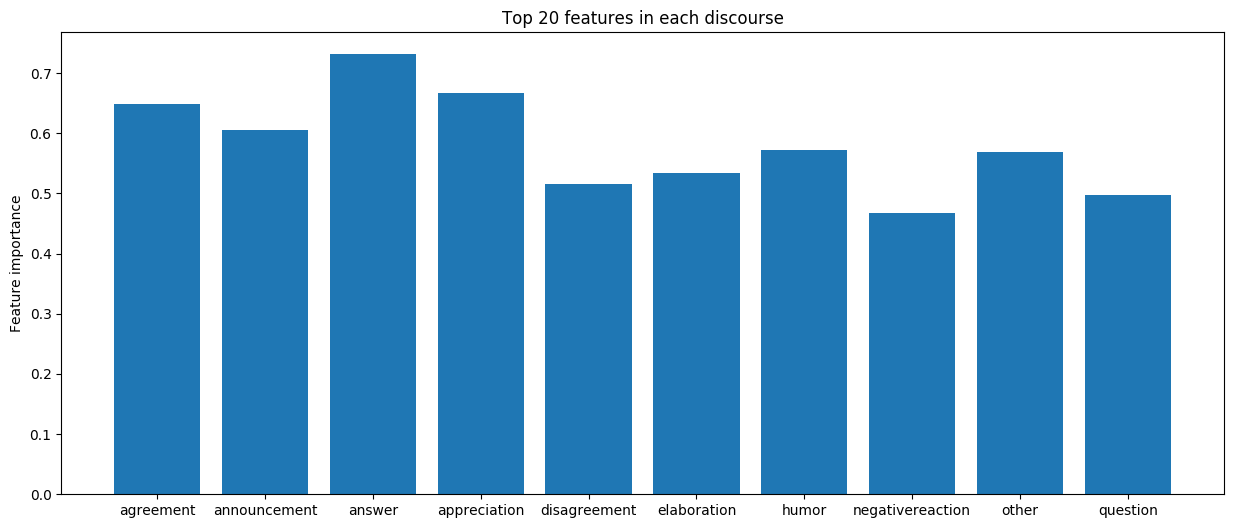

In [50]:
fig = plt.figure(figsize=(15,6))
x=[]   
C_counts= np.zeros(len(collabels))
collabels = ['agreement','announcement','answer','appreciation','disagreement','elaboration','humor','negativereaction','other','question']
Clab = pd.DataFrame(abs_coef_all_new, columns=collabels)
for i in range(len(collabels)):
  C_counts[i] =np.mean(Clab[collabels[i]].nlargest(20))

# x=[C1_counts,C2_counts,C3_counts,C4_counts,C5_counts,C6_counts,C7_counts,C8_counts,C9_counts,C10_counts]

plt.bar(collabels,C_counts)

plt.ylabel('Feature importance')
plt.title('Top 20 features in each discourse')

C_counts

In [37]:
Clab['C1'].nlargest(20)

202276    2.845146
61815     1.067591
82452     0.942043
82458     0.771899
57209     0.608746
82447     0.531930
82455     0.530547
82435     0.520439
82441     0.519636
164907    0.518311
82459     0.446111
61839     0.444542
82457     0.443058
82438     0.421593
164910    0.416502
82434     0.408623
164917    0.404761
41219     0.396157
164920    0.368698
16698     0.366477
Name: C1, dtype: float64